In [1]:
import pandas as pd
import os
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

import haversine

import lightgbm as lgb

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

from datetime import timedelta

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


from keras.models import Sequential
from keras import backend
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
os.environ['KMP_DUPLICATE_LIB_OK']='True' # workaround for keras

/Users/nigel.hussain/anaconda3/envs/MLpy37/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


# Workflow Outline

### Workflow (Predicting the Travel Time):

#### Section 1: Load Data

    convert csv file into pandas dataframe
    

#### Section 2: Data Cleaning

    Dropping features
    
    Removing Outliers
    
    Remove Null values 
    
    Remove out of order stations
    

#### Section 3: Feature Engineering/Insight Analysis

    Perform Feature Engineering and use these newly constructed features to generate insights
    
    Main Features to explore:
    
        Date of Travel
        
        Distance
        
        Weather
        

#### Section 4: Split dataset into training and testing set:
    
    70/30 split for the training and "hold-out" testing set
    

#### Section 5: Train/Test a few models: 

    linear regression
    
    random forest
    
    neural network
    
    Dummy variable: used as a baseline
    
    
#### Section 6: Final Remarks

    Final Thoughts on Dataset
    
    Changes for a future Experiment
    
    Comments on Model Fit
    
    Final Justification for Workflow
    
    
#### Section 7: Model Prediction without any Feature Engineering

# Section 1: Loading the Data

The first step for any data science analysis is to load the dataset on an appropiate data structure (in this case a pandas dataframe). This is done because a dataframe is specifically designed for these purposes.

In [2]:
stations = pd.read_csv('hubway_stations.csv')
trips = pd.read_csv('hubway_trips.csv')
weather = pd.read_csv('weather.csv')

Next, I decided to print out the column names and the number of rows a good idea of what features are being used and how they can be manipulated to create additional features

In [3]:
print(stations.columns)
print(stations.shape[0])

Index(['id', 'terminal', 'station', 'municipal', 'lat', 'lng', 'status'], dtype='object')
142


In [4]:
print(trips.columns)
print(trips.shape[0])

Index(['seq_id', 'hubway_id', 'status', 'duration', 'start_date', 'strt_statn',
       'end_date', 'end_statn', 'bike_nr', 'subsc_type', 'zip_code',
       'birth_date', 'gender'],
      dtype='object')
1048575


In [5]:
print(weather.columns)
print(weather.shape[0])

Index(['STATION', 'STATION_NAME', 'ELEVATION', 'LATITUDE', 'LONGITUDE', 'DATE',
       'HPCP', 'Measurement_Flag', 'Quality_Flag'],
      dtype='object')
2654


# Section 2: Data Cleaning

The first step for any data pipeline is to clean the data as bad data tends to yield bad predictions.

## 2.1: Removing Features

First, I would like to drop some features, as these should not have any impact on the predictive qualities after looking over the contents provided in the document.

1) end date--> redundant as we already have the duration of the trip

2) zip_code --> irrelevant as we are more interested in the users start station, not the home address

3) birth_Date --> note enough information (I would rather not make assumptions based solely off of people's birthdate --> more information would be required to justify the use of this information)

4) Gender --> not enough information to use (I would rather not make assumptions based solely off of people's gender --> more information would be required to justify the use of this information)

5) Bike Number --> irrelevant

6) seq_id --> irrelevant

7) hubway_id --> irrelevant

8) Sybsc_type --> irrelevant

In [6]:
# Here we have to drop the useless information, as that will not be used in prediction and/or is redundant information
trips = trips.drop(['end_date', 'zip_code','birth_date','gender', 'bike_nr', 'seq_id', 'hubway_id', 'subsc_type'], 1)

## 2.2: Removing Outliers

First, we have to remove outliers in the target variable. First, though we have to examine the values themselves.

In [7]:
trips.duration.describe()

count    1.048575e+06
mean     1.362366e+03
std      3.237631e+04
min     -6.660000e+03
25%      4.200000e+02
50%      6.640000e+02
75%      1.140000e+03
max      1.199446e+07
Name: duration, dtype: float64

Here we notice that some of the journeys are either abnormally long (3300 hours) or negative, meaning that some of the data are outliers and decided that we should remove some of them. To determine this, I decided that it was best to remove outliers after a certain percentile

In [8]:
# The values are in minutes
print(np.percentile(trips.duration, 75)/60)
print(np.percentile(trips.duration, 80)/60)
print(np.percentile(trips.duration, 99)/60)
print(np.percentile(trips.duration, 99.5)/60)
print(np.percentile(trips.duration, 99.6)/60)
print(np.percentile(trips.duration, 99.8)/60)
print(np.percentile(trips.duration, 99.85)/60)
print(np.percentile(trips.duration, 99.9)/60)
print(np.percentile(trips.duration, 99.99)/60)
print(np.percentile(trips.duration, 99.999)/60)
print(np.percentile(trips.duration, 99.9999)/60)
print(trips.duration.max()/60)

19.0
21.666666666666668
139.06666666666666
221.05216666666675
263.1185333333347
607.9975333333326
815.5838499999838
1133.5201000000486
4681.013389999668
96987.28185699142
177283.0254906182
199907.63333333333


The values that would be the most unreasonable in this case would be the ones after 607.997 minutes (99.85 percentile), as bicycle trips longer than 10 hours will rarely, if ever, happen.

In [9]:
# we choose to remove the ones above the 99.85 percentiles
trips = trips[trips.duration <= np.percentile(trips.duration, 99.85)]
trips.duration.describe()

count    1.047002e+06
mean     1.063912e+03
std      1.845449e+03
min     -6.660000e+03
25%      4.200000e+02
50%      6.620000e+02
75%      1.140000e+03
max      4.893100e+04
Name: duration, dtype: float64

In [10]:
# Now we should remove the negative values
trips = trips[trips.duration >= 0]
trips.duration.describe()

count    1.046984e+06
mean     1.064033e+03
std      1.845236e+03
min      0.000000e+00
25%      4.200000e+02
50%      6.620000e+02
75%      1.140000e+03
max      4.893100e+04
Name: duration, dtype: float64

## 2.3: Null values

Now we have to check for the existence of null values.

In [11]:
trips.isnull().sum()

status         0
duration       0
start_date     0
strt_statn    13
end_statn     30
dtype: int64

Due to the small amount of null values, the massive size of the dataset, and the fact that there doesn't seem to be a way to retrieve these values, we can just simply remove them

In [12]:
trips = trips.dropna()

In [13]:
# Sanity check

trips.isnull().sum()

status        0
duration      0
start_date    0
strt_statn    0
end_statn     0
dtype: int64

## 2.4: Remove inoperative stations

In addition, after examining the station_hub information, I have seen thats  some of the stations no longer exist. We have to figure out which ones are there and remove them, as these stations are now irrelevant. To accomplish this, I put these removed stations into a list and removed the rows that contained them

In [14]:
stations_removed = stations.loc[stations.status == 'Removed']

stations_removed

id terminal                                            station  municipal  \
10  13   C32002             Boston Medical Center - 721 Mass. Ave.     Boston   
20  23   B32008         Mayor Thomas M. Menino - Government Center     Boston   
30  34   B32009                       Overland St at Brookline Ave     Boston   
31  35   D32004                              Summer St. / Arch St.     Boston   
33  37   D32001                         New Balance - 38 Guest St.     Boston   
34  38   D32003                            TD Garden - Legends Way     Boston   
52  56   B32017                                      Dudley Square     Boston   
56  60   D32016      Charles Circle - Charles St. at Cambridge St.     Boston   
57  61   C32008                              Boylston at Fairfield     Boston   
78  82   K32002        Brookline Town Hall / Library Washington St  Brookline   
81  85   C32012     Andrew Station - Dorchester Ave at Humboldt Pl     Boston   
93  97   M32015  Harvard  University River Houses at DeWolfe St...  Cambridge   

          lat        lng   status  
10  42.334057 -71.074030  Removed  
20  42.359677 -71.059364  Removed  
30  42.346171 -71.099855  Removed  
31  42.354594 -71.058960  Removed  
33  42.357247 -71.146452  Removed  
34  42.366231 -71.060868  Removed  
52  42.328190 -71.083354  Removed  
56  42.360877 -71.071310  Removed  
57  42.348323 -71.082674  Removed  
78  42.333689 -71.120526  Removed  
81  42.330825 -71.057007  Removed  
93  42.369182 -71.117152  Removed

In [15]:
stations_id = stations_removed.id.values

stations_id

array([13, 23, 34, 35, 37, 38, 56, 60, 61, 82, 85, 97])

In [16]:
trips = trips[~trips['strt_statn'].isin(stations_id)]

In [17]:
trips = trips[~trips['end_statn'].isin(stations_id)]

# Section 3: Feature Extraction/Insight Generation

After cleaning the data, we should explore how we can transform the features into more useful ones,as better features yield better results.

Thus, in this section, I modified the features and added new ones to explore relationships of these features with the target value. This will be done by generating a new feature, hypothesising the effect of that feature on the target variable, and then testing that hypothesis with the appropiate method. This method is robus in the sense that features with very little predictive power will be filtered out during the experimentation phase.

I would hypothesise that the three factors which would have the greatest effect on the trip duration are: 

1) time

2) weather 

3) distance

Each of these features have their own "sub-features" (for example "day of travel" would be a subfeature of time) which can be used to explore the potentially complex relationship between these features and the target variable. The idea behind the generation of these subfeatures is to use relatively straightforward features due to time constraints.

## 3.2: Impact of date of travel on trip duration:

This section will focus on creating features related to the date of travel and testing and hypothesising about the relationship between the time of travel and the trip duration

In [18]:
print(trips.start_date.max())
print(trips.start_date.min())

9/30/2012 23:59:00
04/01/2012 00:21


In [19]:
# Convert to datetime
trips.start_date = pd.to_datetime(trips.start_date)

First we should do an initial graph to get and idea of how the trip duration changed with the time

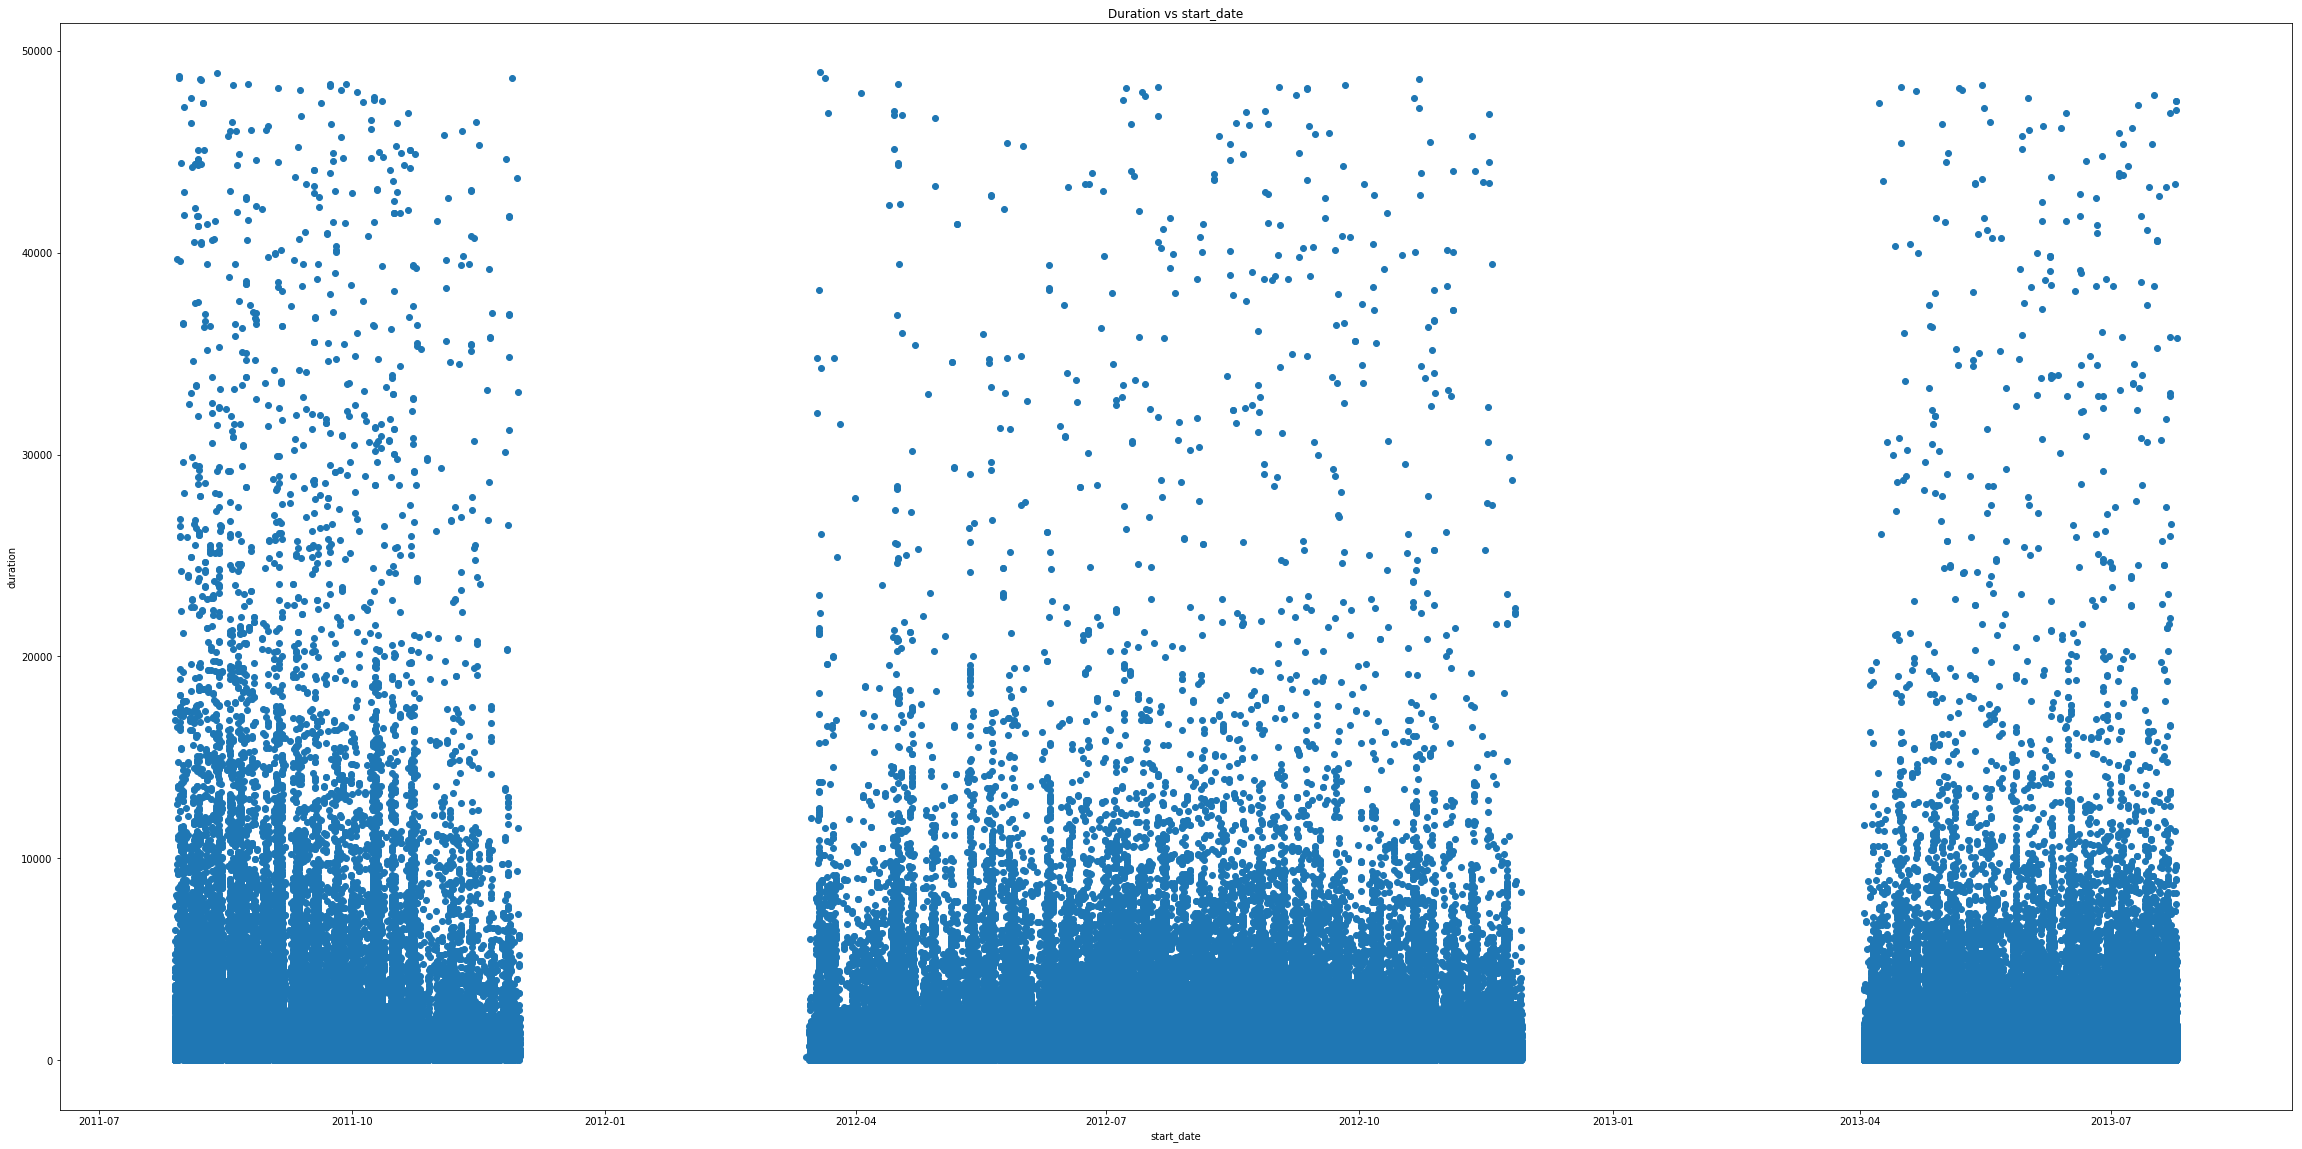

In [20]:
plt.figure(figsize=(40,20))
plt.scatter(trips.start_date, trips.duration)
plt.title('Duration vs start_date')
plt.xlabel('start_date')
plt.ylabel('duration')
plt.show()

As we can see, there does seem to be periods where the duration increases in relation to the time. In this case, I would say that while there definitely is a relationship between date of travel and duration, we need to do some more investigation

### Minute of Day

First, we have to create a new feature which indicates what "minute of day" each trip was done. This will give us a good representation of the time of day that each bicycle trip occured. I do believe that there is a relationship between the time of day and the trip duration. I will test this result by plotting a scatterplot of the target variable vs the new feature.

In [21]:
# Calculate what minute in a day the pickup is at
trips['start_minute_of_the_day'] = trips.start_date.dt.hour*60 + trips.start_date.dt.minute

In [22]:
# Visualise the impact
plt.figure(figsize=(40,20))
plt.scatter(trips.start_minute_of_the_day, trips.duration)
plt.title('Duration vs start_minute_of_the_day')
plt.xlabel('start_minute_of_the_day')
plt.ylabel('duration')
plt.show()

From the data, we can see there is a clear pattern (once we count for outliers). From midnight, the bicycle trip durations steadily decrease until there about 400 minutes after midnight, in which case we start to see an increase in the trip duration. This makes sense because the streets and tend to get busier as people have to start going to work, etc and generally accomplish their tasks during this hour, which would mean the pathways would get a bit busier. Naturally, as the average trip duration seems to decrease after about 900 minutes after midnight, which makes sense as this would correspond to the evening time, where people are at home as opposed to on the streets. Thus, we can assume that the time of day does have a major impact on the travel duration, and thus it would be wise to include this feature. In addition, a lot of the values above the almost sinusoidal graph (those above 10,000 seconds appear to be a bit unreasonable as it would be a stretch to assume that an average bicycle trip would take around 3 hours, especially during the times when there is little to no traffic) can be considered outliers, especially those that occur during the early morning, which is when traffic is at a minimum.

### Remove additional Outliers

As our previous analysis has revealed that there are still a significant amount of outliers, we have to remove them again. We will use the same method as bbefore (removing by percentile)

In [23]:
print(np.percentile(trips.duration, 75)/60)
print(np.percentile(trips.duration, 80)/60)
print(np.percentile(trips.duration, 85)/60)
print(np.percentile(trips.duration, 90)/60)
print(np.percentile(trips.duration, 95)/60)
print(np.percentile(trips.duration, 99)/60)
print(np.percentile(trips.duration, 99.5)/60)
print(np.percentile(trips.duration, 99.6)/60)
print(np.percentile(trips.duration, 99.8)/60)
print(np.percentile(trips.duration, 99.85)/60)
print(np.percentile(trips.duration, 99.9)/60)
print(np.percentile(trips.duration, 99.99)/60)
print(np.percentile(trips.duration, 99.999)/60)
print(np.percentile(trips.duration, 99.9999)/60)
print(trips.duration.max()/60)

19.0
21.25
24.683333333333334
29.316666666666666
47.46666666666667
126.58033333333442
182.0
204.68333333333334
288.56606666666534
337.3666666666667
429.80083333346215
766.1039799998592
806.0649268333004
814.9885989166544
815.5166666666667


To determine which values should be kept, I had to determine to use google maps which two stations were the furthest from each other and the time it takes to cycle between them, which in this case was 56 minutes. In addition, after accounting for traffic, and realised that we should only keep the values that are less than or equal to 126 minutes, as a 2 hour bicycle ride isn't out of the realm of possibilities given heavy traffic.

In [24]:
trips = trips[trips.duration <= np.percentile(trips.duration, 99)]
trips.duration.describe()

count    896207.000000
mean        920.973823
std         908.336182
min           0.000000
25%         409.000000
50%         660.000000
75%        1121.000000
max        7594.000000
Name: duration, dtype: float64

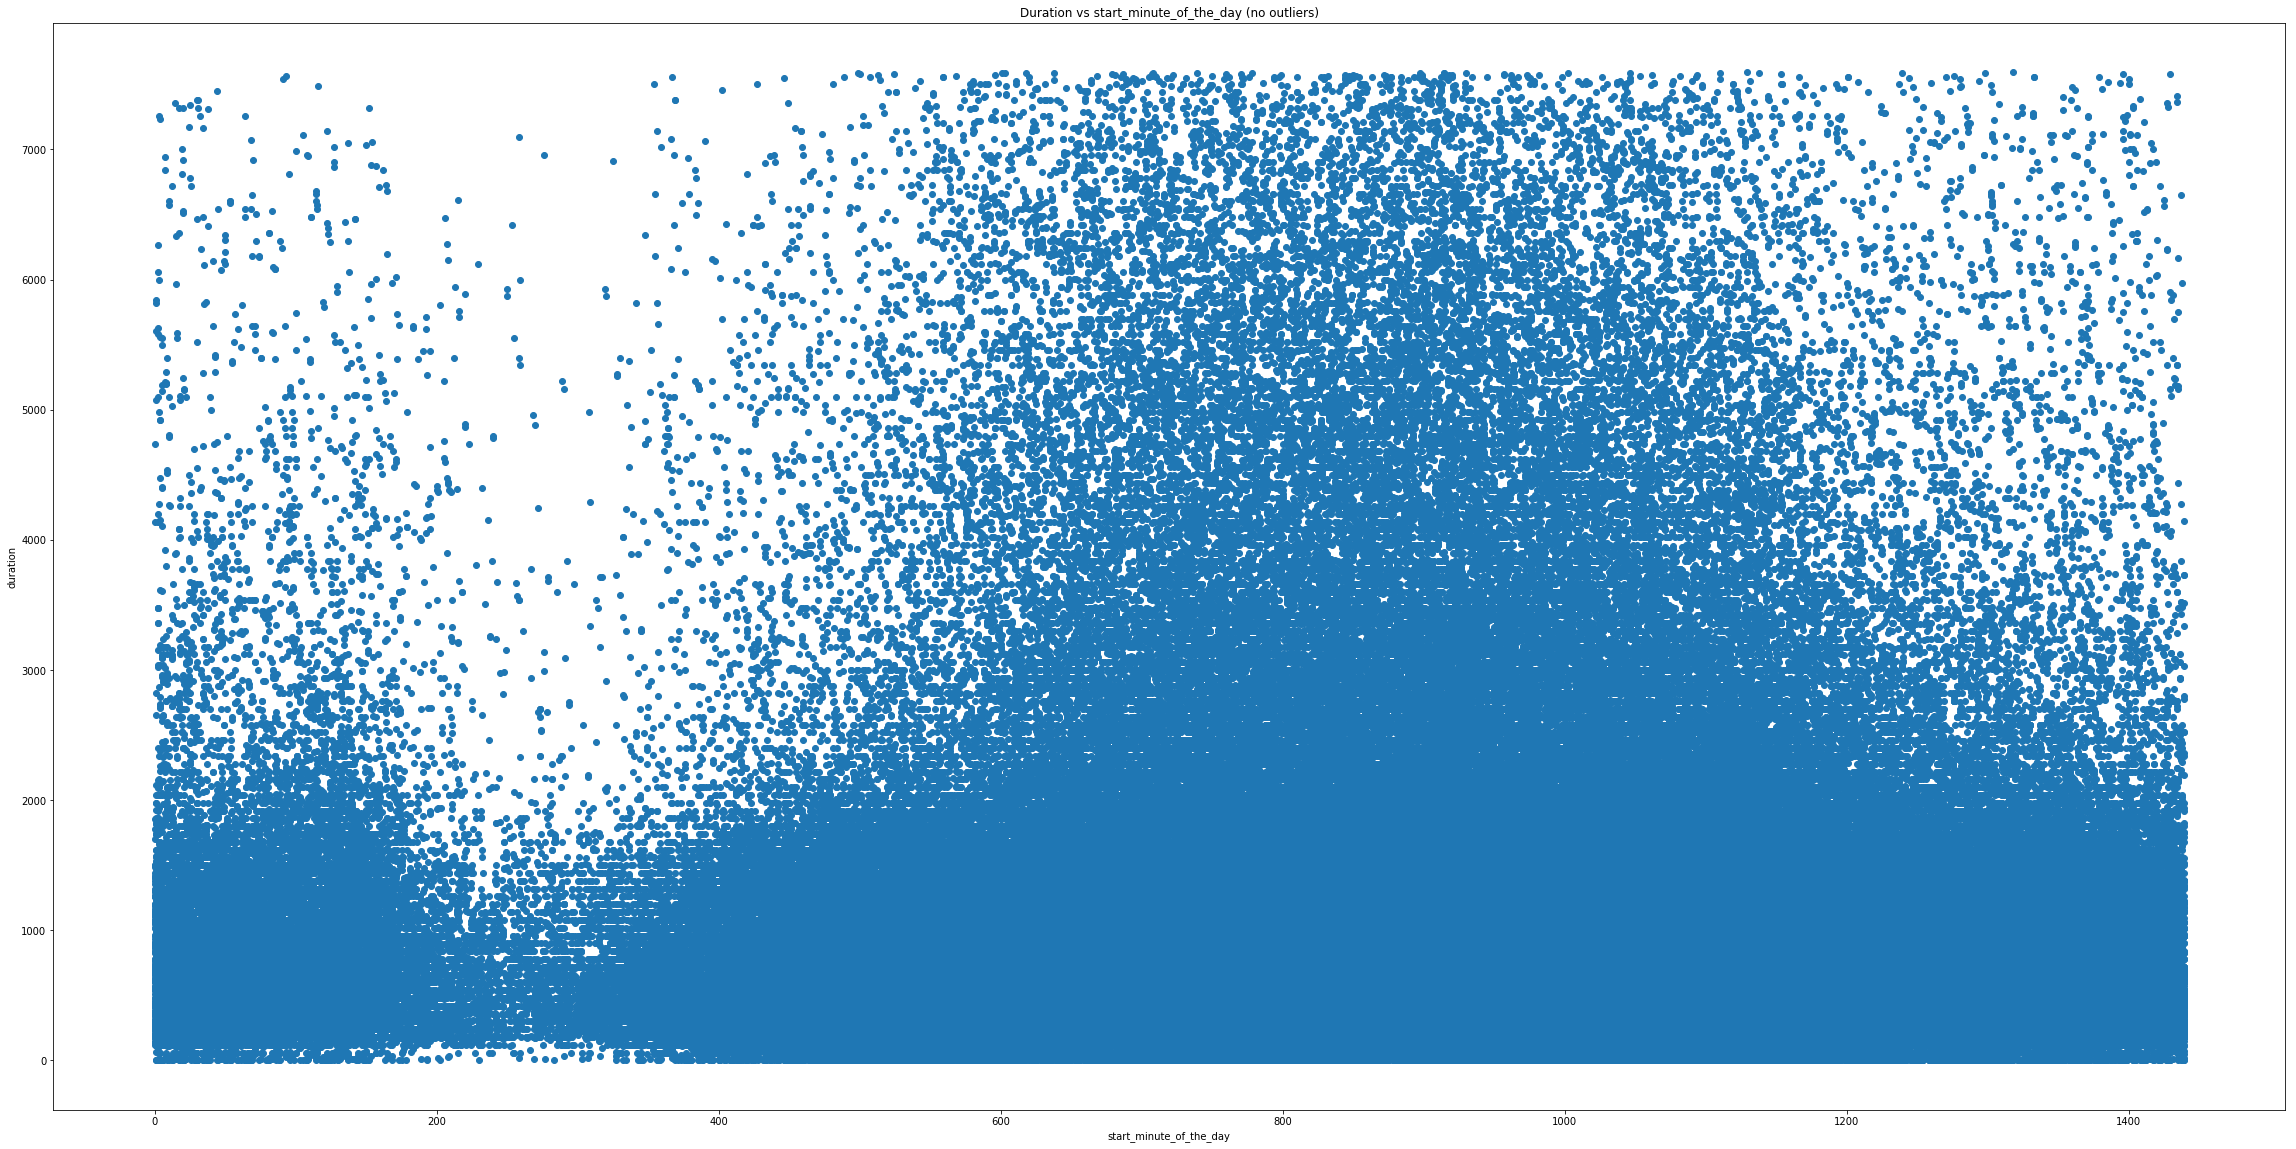

In [25]:
# Visualise the impact
plt.figure(figsize=(40,20))
plt.scatter(trips.start_minute_of_the_day, trips.duration)
plt.title('Duration vs start_minute_of_the_day (no outliers)')
plt.xlabel('start_minute_of_the_day')
plt.ylabel('duration')
plt.show()

While the dataset itself still isn't quite outlier free, we can see a clearer sinusoidal relationship between the two variables. However, I would like to do a bit more data exploration before further outlier removal.

### Generating Additional Features

In addition, there are several other time related factors that can have an impact on the traveling time. These are the start month, the day of the week, whether the trip is on the weekend, on a holiday, near a holiday, on a business day, and additionally, the minute of the week/week_delta (This is a way to represent the time of the week as a number as opposed to a date time object) 

All of these will be covered individually. 

In [26]:
# Load a list of holidays in the US
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

# Load business days
us_bd = CustomBusinessDay(calendar = USFederalHolidayCalendar())
# Set business_days equal to the work days in our date range.
business_days = pd.DatetimeIndex(start = trips.start_date.min(), 
                                 end = trips.start_date.max(), 
                                 freq = us_bd)
business_days = pd.to_datetime(business_days).date

/Users/nigel.hussain/anaconda3/envs/MLpy37/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  # Remove the CWD from sys.path while we load stuff.


In [27]:
# Create features relating to time
trips['start_month'] = trips.start_date.dt.month
trips['start_weekday'] = trips.start_date.dt.weekday
trips['start_is_weekend'] = trips.start_weekday.map(lambda x: 1 if x >= 5 else 0)
trips['start_holiday'] = pd.to_datetime(trips.start_date.dt.date).isin(holidays)
trips['start_holiday'] = trips.start_holiday.map(lambda x: 1 if x == True else 0)

# If day is before or after a holiday
trips['start_near_holiday'] = (pd.to_datetime(trips.start_date.dt.date).isin(holidays + timedelta(days=1)) |
                             pd.to_datetime(trips.start_date.dt.date).isin(holidays - timedelta(days=1)))
trips['start_near_holiday'] = trips.start_near_holiday.map(lambda x: 1 if x == True else 0)
trips['start_businessday'] = pd.to_datetime(trips.start_date.dt.date).isin(business_days)
trips['start_businessday'] = trips.start_businessday.map(lambda x: 1 if x == True else 0)

# Calculates what minute of the week it is
trips['week_delta'] = (trips.start_weekday + ((trips.start_date.dt.hour + 
                                              (trips.start_date.dt.minute / 60.0)) / 24.0))

### Week Delta

I do predict that there will be a relationship between the week delta (the floating number representation of the day of the week) and the trip duration, although I am unsure of the nature of the relationship.

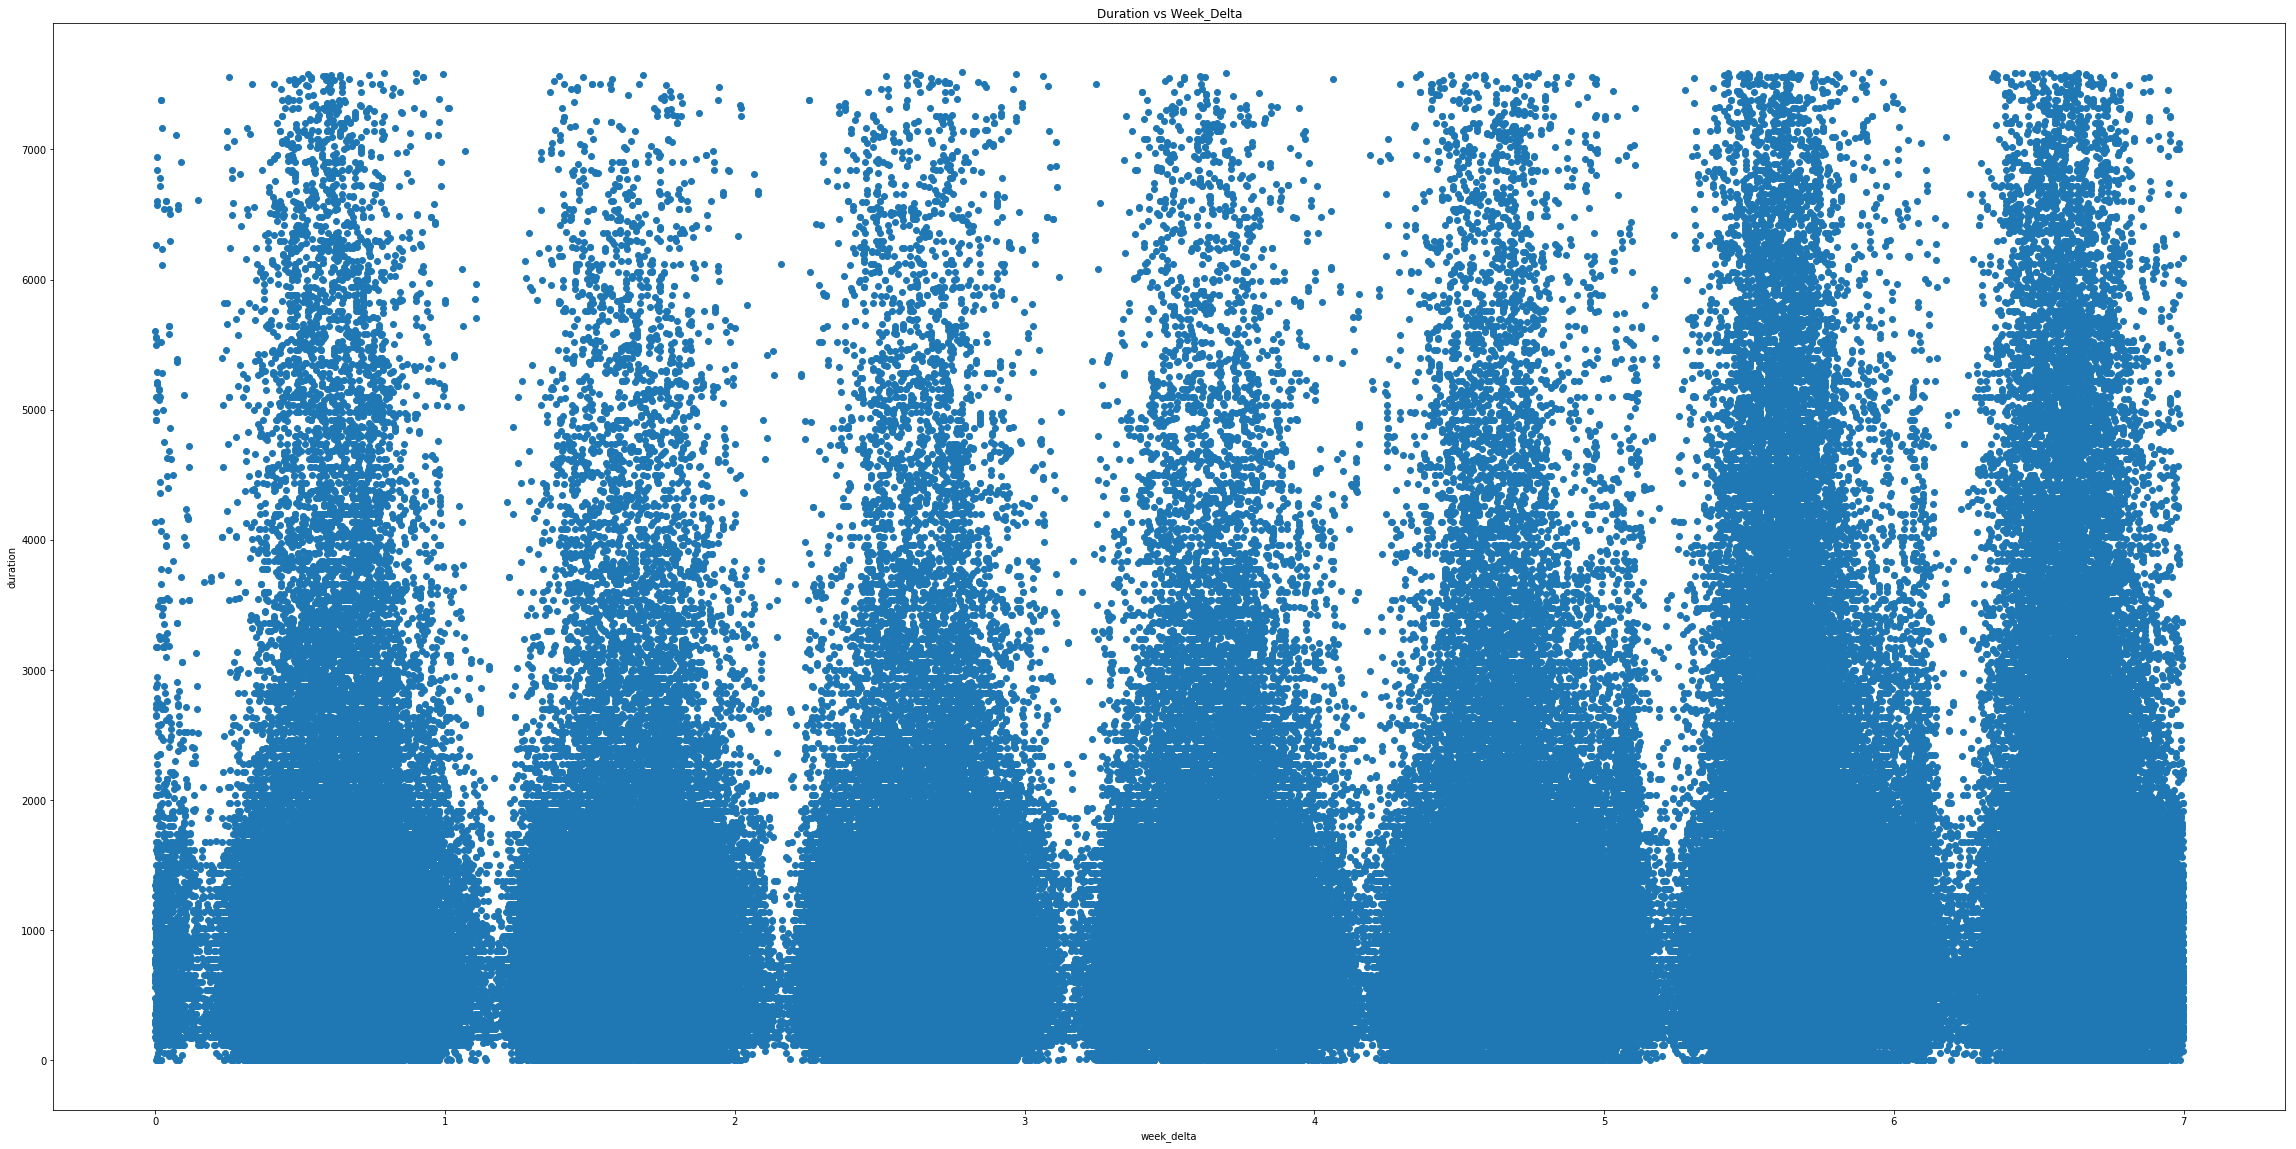

In [28]:
# Visualise the impact of start week minute
plt.figure(figsize=(40,20))
plt.scatter(trips.week_delta, trips.duration)
plt.title('Duration vs Week_Delta')
plt.xlabel('week_delta')
plt.ylabel('duration')
plt.show()

Interestingly, the graph seems to reveal a sinusoidal relationship between the week delta and the trip duration 

However, this relationship is complicated by the presence of additional outliers within the data, as quite a few of them still seem to be excessively large, with no logical explanation, which means that further outlier removal will have to be done. 

However, due to the cyclical nature of this relationship, I believe that a rolling window would be the most appropiate here, as it should filter outliers at each time stamp. Alternatively, we could have attempted to use a groupby function and filter out the outliers within those individual groups, but that would require additional feature engineering to avoid an absurd amount of groups, which isn't possible in a dataframe with almost 1000000 rows and the given amount of time.

In [29]:
# First sort the dataframe values by increasing "week_delta"

trips = trips.sort_values(by = ['week_delta'])

In [30]:
# We will test with standard deviations
r = trips.duration.rolling(200)
mps = r.mean() + 1 * r.std()

In [31]:
# Now we will create a new dataframw for testing out the new values

trips_test = trips[trips.duration < mps]

In [32]:
# Visualise the results
plt.figure(figsize=(40,20))
plt.scatter(trips_test.week_delta, trips_test.duration)
plt.title('Duration vs Week_Delta (no outliers)')
plt.xlabel('week_delta')
plt.ylabel('duration')
plt.show()

By removing the outliers, we can see that this there is a clear (almost sinusoidal) relationship between the time and the trip duration, and this final round of cleaning has also resulted in data that is also much more reasonable, as a bike trip of over 1 hour and 15 min is more acceptable than a bike trip that lasts over 3 hours (from the previous one)

In [33]:
trips_test.duration.describe()

count    803635.000000
mean        700.586882
std         428.319978
min           0.000000
25%         360.000000
50%         600.000000
75%         951.000000
max        3319.000000
Name: duration, dtype: float64

In [34]:
trips = trips_test

### Month

I hypothesise that the prices will be highest during the summer months.

In [35]:
trips.groupby('start_month')['duration'].mean()

start_month
3     656.276573
4     694.502875
5     694.964470
6     720.157348
7     712.870682
8     742.686358
9     712.792190
10    665.993913
11    638.143775
Name: duration, dtype: float64

It would appear that the month of travel does have an impact on the duration of the trip. In particular, August and September have the highest amount of bike travel and the winter month (november/11) has the shortest duration. All other times seem to have a consistent travel time with little variation. This would make sense as most people would prefer to stay indoors during the winter. In addition, the quality of the roads would be worse as the weather conditions worsen during the winter, meaning that the average trip should be shorter.

### Weekday

Since most people are working on the weekdays, I hypothesise that the duration will be higher on the weekdays.

In [36]:
# Visualise the impact of start day
trips.groupby('start_weekday')['duration'].mean()

start_weekday
0    654.015395
1    606.148136
2    618.893346
3    627.964839
4    662.946027
5    881.314558
6    884.672755
Name: duration, dtype: float64

Although, the initial hypothesis is wrong, this analysis has revealed that there is a relationship between the day of travel and the trip duration, as the trips on saturday and sunday are longer, which on reflection would make sense as there should be more people outdoors on the weekends. To confirm this, I added a new feature (is_weekend) which classified a trip as occuring on the weekend or not (in this case 5 and 6) and calculated the mean.

In [37]:
# Visualise the impact of weekends
trips.groupby('start_is_weekend')['duration'].mean()

start_is_weekend
0    634.011067
1    882.945149
Name: duration, dtype: float64

As shown above, trips would take longer on the weekends, thus confirming the results of the previous experiment

### Holiday

Due to the increased amount of travelling, I hypothesise that the duration will be higher on the holidays

In [38]:
# Visualise the impact of start holiday
trips.groupby('start_holiday')['duration'].mean()

start_holiday
0    698.710375
1    780.646074
Name: duration, dtype: float64

As predicted, the amount of traffic increases during the holidays. Again, this might be due to the fact that there are more people traveling on the holidays, which would lead to more traffic. To further test this, we will create 2 more features and see how the means compare with each other.

In [39]:
# Visualise the impact of start near holiday
trips.groupby('start_near_holiday')['duration'].mean()

start_near_holiday
0    699.105763
1    731.669758
Name: duration, dtype: float64

Similarly, the trips on dates that are closer to the holidays would yield a longer travel time, arguably for similar reasons

In [40]:
# Visualise the impact of start businessday
trips.groupby('start_businessday')['duration'].mean()

start_businessday
0    874.875898
1    629.278815
Name: duration, dtype: float64

In addition, the the non-business trips have a higher duration than the non-businessdays ones, which could be explained by the previous factor (holiday).

### Rush Hour

Interestingly, there doesn't seem to be a relationship between our ride_count calculator and the trip duration. And that aside, the calculation itself was simplistic and didn't produce values that were represnetative of the traffic as a whole. Thus, we will drop this feature.

The final factor that we have to account for is rush_hour, which is when the traffic is generally really heavy and results in a longer trip time. While bicycles could work around this, it is still affected as they could have to use alternative routes which could take longer. As no data is present regarding rush hour, we would have to calculate this ourselves.

The way that we are going to accomplish this is by using the k-means clustering model and group them into 24 clusters (to represent the 24 hours). This should help sort the data by "rush hours".

In [41]:
kmeans_start_time = KMeans(n_clusters=24, random_state=2).fit(trips.start_minute_of_the_day.values.reshape(-1,1))

In [42]:
trips['kmeans_start_time'] = kmeans_start_time.predict(trips.start_minute_of_the_day.values.reshape(-1,1))

### Traffic

Finally, the amount of traffic at each hour should also have a big impact on the time traveled, In this case, I would expect a linear relationship between the duration and the amount of traffic (more traffic = more duration time). The approach detailed below should give us a good estimator of howe to find the amount of traffic. 

In [43]:
# Determines number of rides that occur during each specific time
# Should help to determine traffic

ride_counts = trips.groupby(['start_month', 'start_weekday','start_holiday','start_near_holiday',
            'start_businessday','kmeans_start_time']).size()


ride_counts = pd.DataFrame(ride_counts).reset_index()
ride_counts['ride_counts'] = ride_counts[0]
ride_counts = ride_counts.drop(0,1)

# Add `ride_counts` to dataframe
trips = trips.merge(ride_counts, on=['start_month',
                          'start_weekday',
                          'start_holiday',
                          'start_near_holiday',
                          'start_businessday',
                          'kmeans_start_time'], how='left')

In [44]:
# Visualise the results
plt.figure(figsize=(40,20))
plt.scatter(trips.ride_counts, trips.duration)
plt.title('Duration vs Ride Counts')
plt.xlabel('ride_counts')
plt.ylabel('duration')
plt.show()

Interestingly, the results indicated that there was no clear relationship between the traffic data and the duration of the ride. However, this can be explained due to the oversimplied nature of this calculation, which produces a value that is not representative of the overall traffic. As a result of these factors, the feature was dropped.

In [45]:
trips = trips.drop('ride_counts', axis =1)

In [46]:
# Sanity Check
trips.head()

status  duration          start_date  strt_statn  end_statn  \
0  Closed       432 2012-07-16 00:09:00        22.0        6.0   
1  Closed      1080 2013-06-24 00:09:00        14.0       66.0   
2  Closed       180 2013-06-24 00:09:00        55.0       45.0   
3  Closed       300 2013-06-24 00:09:00       103.0       46.0   
4  Closed       435 2012-07-16 00:09:00        22.0       47.0   

   start_minute_of_the_day  start_month  start_weekday  start_is_weekend  \
0                        9            7              0                 0   
1                        9            6              0                 0   
2                        9            6              0                 0   
3                        9            6              0                 0   
4                        9            7              0                 0   

   start_holiday  start_near_holiday  start_businessday  week_delta  \
0              0                   0                  1     0.00625   
1              0                   0                  1     0.00625   
2              0                   0                  1     0.00625   
3              0                   0                  1     0.00625   
4              0                   0                  1     0.00625   

   kmeans_start_time  
0                 12  
1                 12  
2                 12  
3                 12  
4                 12

### Final Comments:

I would say that overall, the time that the trip is occuring does have an (complex) impact on the duration of the trip, as shown by all of the experiments. Thus, I will include all of these features in the prediction. 
 

## 3.3: Impact of Distance on Trip Duration

Here we are testing and hypothesising about the relationship between distance traveled and the time duration

Before we do this however, we need to create lookup dictionaries, which will be done by using the station as a key in the dictionary and the corresponding latitude and longitutde for the station as the values. After replacing the values with the values in the dictionary, we will then use the latitude and the longtitude to calculate various distances between the two stations. The haversine distance is used when given the latitude and the longtitude coordinates of a location, as well as the manhattan distance and just theb regular distance between two coordinates.

However, while haversine distances are useful, there are also other distances that can be used in the calculation, including manhattan distances and regular distances. I decided to include them to account for differences in calculations

In addition, I do predict a linear relationship between the distance and the trip duration (longer distance = longer trip duration).

In [47]:
# Create the latitude look up dictionary
LatLookUpDict = {row[1]:row[2] for row in stations[['id','lat']].itertuples()}

In [48]:
# sanity check (uncomment to verify)

# LatLookUpDict

In [49]:
# create the longtitude look up dictionary
LongLookUpDict = {row[1]:row[2] for row in stations[['id','lng']].itertuples()}

In [50]:
# sanity check (uncomment to verify)

# LongLookUpDict

In [51]:
trips['start_lat'] = trips['strt_statn']

trips['start_long'] = trips['strt_statn']

trips['end_lat'] = trips['end_statn']

trips['end_long'] = trips['end_statn']

In [52]:
trips = trips.replace({'start_lat': LatLookUpDict})

trips = trips.replace({'end_lat':LatLookUpDict})

trips = trips.replace({'start_long': LongLookUpDict})

trips = trips.replace({'end_long': LongLookUpDict})

In [53]:
# Create distance features

trips['distance'] = np.sqrt(np.power(trips['end_long'] - trips['start_long'], 2) + 
                         np.power(trips['end_lat'] - trips['start_lat'], 2))



trips['haversine_distance'] = trips.apply(lambda r: haversine.haversine((r['start_lat'],r['start_long']),
                                                                  (r['end_lat'], r['end_long'])), axis = 1)

trips['manhattan_distance'] = (abs(trips.end_long - trips.start_long) +
                            abs(trips.end_lat - trips.start_lat))

In [54]:
# make sure that everything is working properly
trips.head()

status  duration          start_date  strt_statn  end_statn  \
0  Closed       432 2012-07-16 00:09:00        22.0        6.0   
1  Closed      1080 2013-06-24 00:09:00        14.0       66.0   
2  Closed       180 2013-06-24 00:09:00        55.0       45.0   
3  Closed       300 2013-06-24 00:09:00       103.0       46.0   
4  Closed       435 2012-07-16 00:09:00        22.0       47.0   

   start_minute_of_the_day  start_month  start_weekday  start_is_weekend  \
0                        9            7              0                 0   
1                        9            6              0                 0   
2                        9            6              0                 0   
3                        9            6              0                 0   
4                        9            7              0                 0   

   start_holiday  ...  start_businessday  week_delta  kmeans_start_time  \
0              0  ...                  1     0.00625                 12   
1              0  ...                  1     0.00625                 12   
2              0  ...                  1     0.00625                 12   
3              0  ...                  1     0.00625                 12   
4              0  ...                  1     0.00625                 12   

   start_lat  start_long    end_lat   end_long  distance  haversine_distance  \
0  42.352175  -71.055547  42.361285 -71.065140  0.013229            1.283542   
1  42.337171  -71.102797  42.348607 -71.134010  0.033242            2.863191   
2  42.347265  -71.088088  42.344763 -71.097880  0.010107            0.851472   
3  42.348762  -71.082383  42.343864 -71.085918  0.006040            0.617273   
4  42.352175  -71.055547  42.362811 -71.056067  0.010649            1.183442   

   manhattan_distance  
0            0.018703  
1            0.042649  
2            0.012294  
3            0.008433  
4            0.011156  

[5 rows x 21 columns]

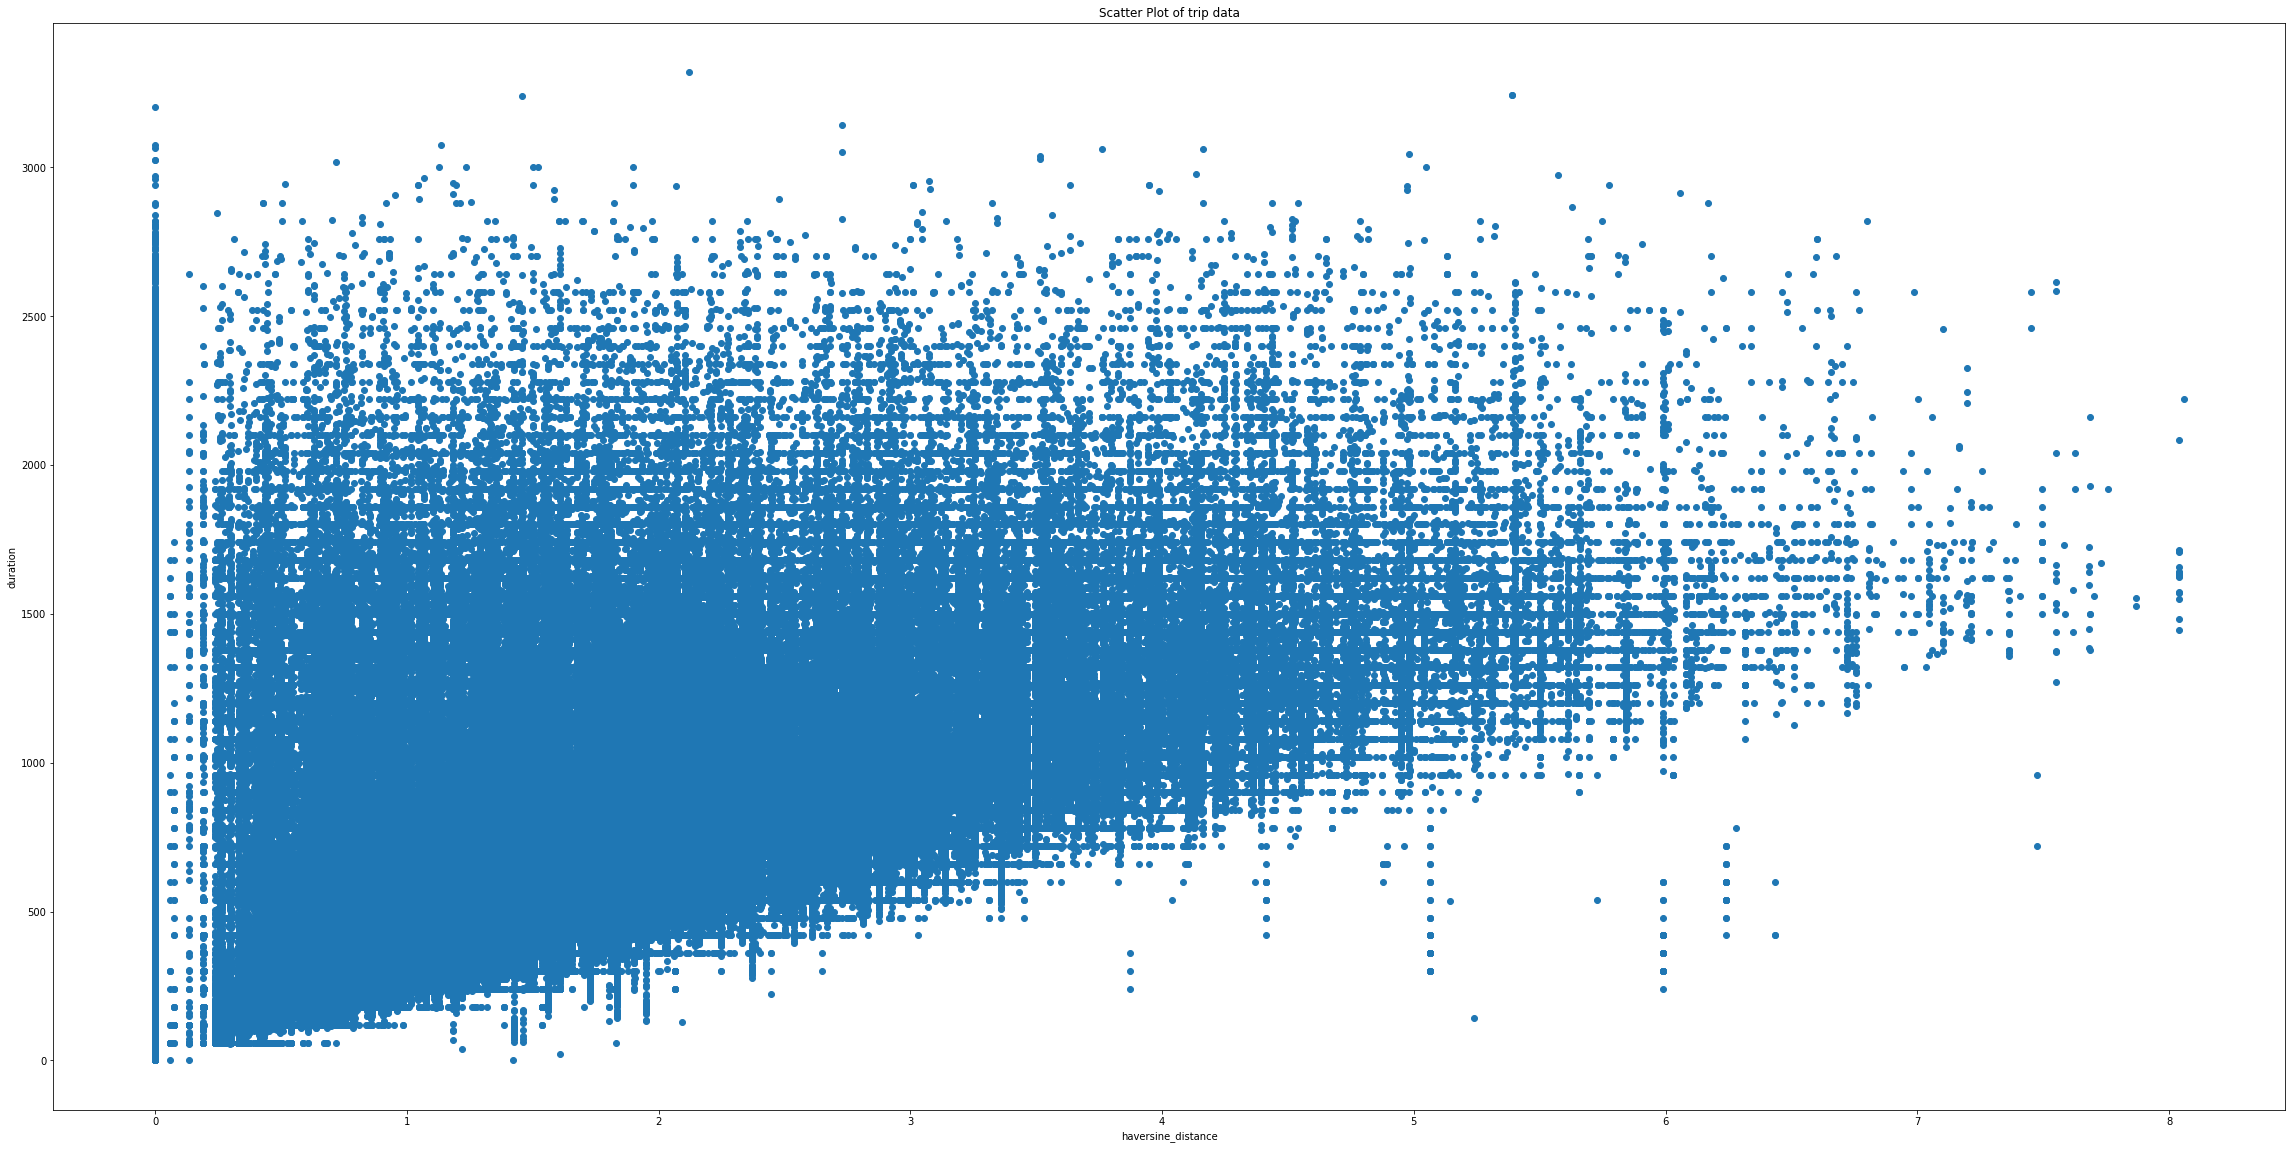

In [55]:
# Visualise the results for haversine distance
plt.figure(figsize=(40,20))
plt.scatter(trips.haversine_distance, trips.duration)
plt.title('Scatter Plot of trip data')
plt.xlabel('haversine_distance')
plt.ylabel('duration')
plt.show()

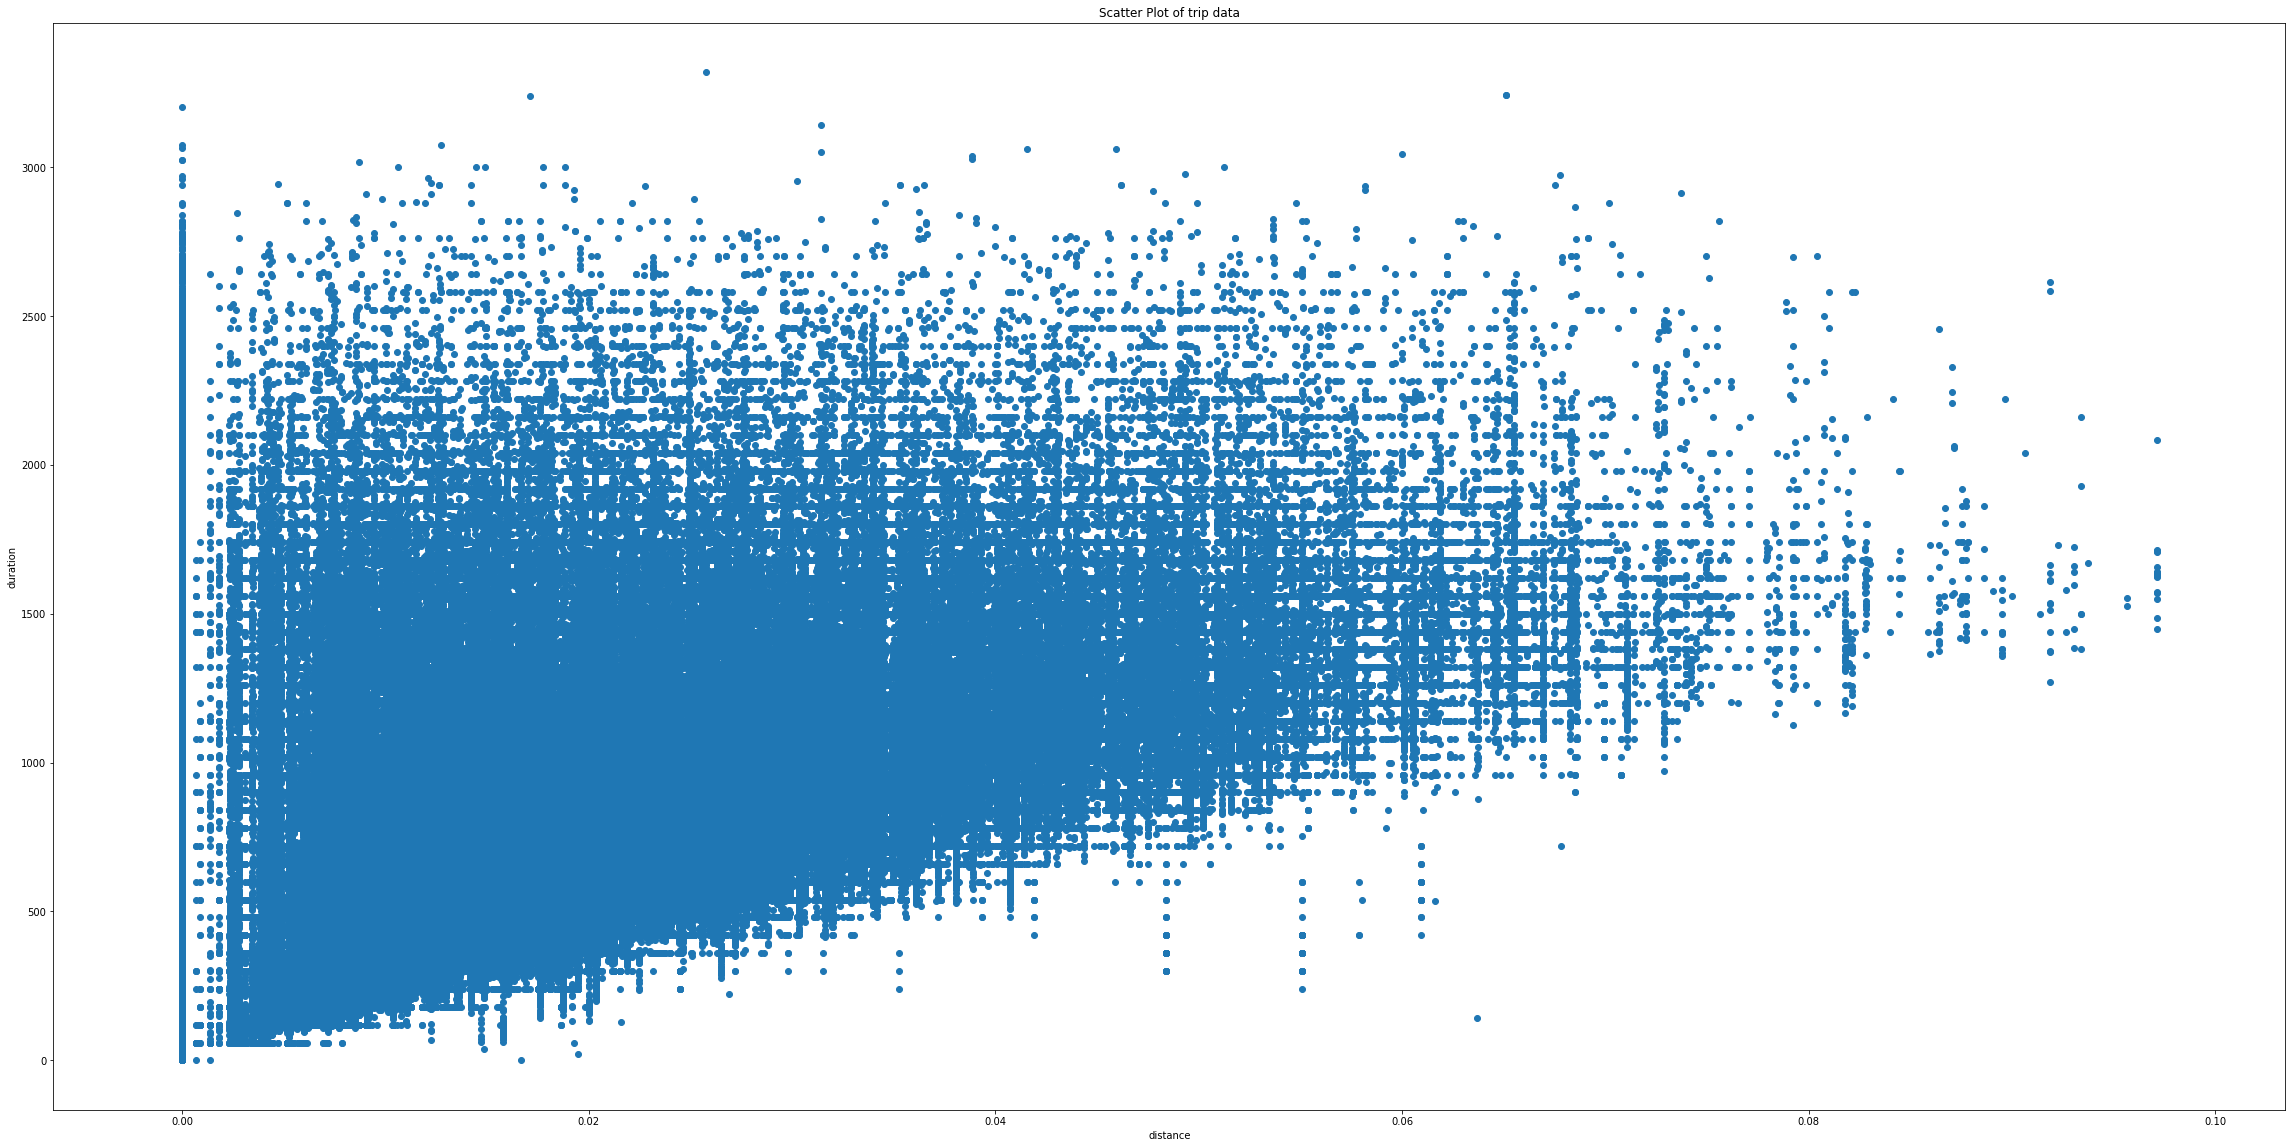

In [56]:
# Visualise the results for regular distance
plt.figure(figsize=(40,20))
plt.scatter(trips.distance, trips.duration)
plt.title('Scatter Plot of trip data')
plt.xlabel('distance')
plt.ylabel('duration')
plt.show()

In [57]:
# Visualise the results for manhattan distance
plt.figure(figsize=(40,20))
plt.scatter(trips.manhattan_distance, trips.duration)
plt.title('Scatter Plot of trip data')
plt.xlabel('manhattan_distance')
plt.ylabel('duration')
plt.show()

From the graphs, it would appear that in general, while there was still a bit of variation in the data, we can at least see that the minimum traveling time generally increases for all values, meaning that the distances should be included in the training data

### Bearing 

Another feature that can aid in prediction of trip duration is bearing, which is the direction of travel in degrees. While I am unsure of the nature of the relationship, I do hypothesise that there is one between bearing and trip duration.

In [58]:
def calculate_bearing(start_lat, start_long, end_lat, end_long):
    
    '''Calculate the direction of travel in degrees'''
    
    start_lat_rads = np.radians(start_lat)
    start_long_rads = np.radians(start_long)
    end_lat_rads = np.radians(end_lat)
    end_long_rads = np.radians(end_long)
    long_delta_rads = np.radians(end_long_rads - start_long_rads)
    
    y = np.sin(long_delta_rads) * np.cos(end_lat_rads)
    x = (np.cos(start_lat_rads) * 
         np.sin(end_lat_rads) - 
         np.sin(start_lat_rads) * 
         np.cos(end_lat_rads) * 
         np.cos(long_delta_rads))
    
    return np.degrees(np.arctan2(y, x))

In [59]:
trips['bearing'] = calculate_bearing(trips.start_lat,
                                  trips.start_long,
                                  trips.end_lat,
                                  trips.end_long)

In [60]:
# Sanity check
trips.columns

Index(['status', 'duration', 'start_date', 'strt_statn', 'end_statn',
       'start_minute_of_the_day', 'start_month', 'start_weekday',
       'start_is_weekend', 'start_holiday', 'start_near_holiday',
       'start_businessday', 'week_delta', 'kmeans_start_time', 'start_lat',
       'start_long', 'end_lat', 'end_long', 'distance', 'haversine_distance',
       'manhattan_distance', 'bearing'],
      dtype='object')

In [61]:
plt.figure(figsize=(40,20))
plt.scatter(trips.bearing, trips.duration)
plt.title('Duration vs Bearing')
plt.xlabel('bearing')
plt.ylabel('duration')
plt.show()

Interestingly, there seems to be some sort of sinusoidal relationship between the bearing and the distance traveled. Unfortunately, the lack of data in certain bearings means that this prediction isn't fully conclusive. Furthermore, the lack of additional data prevents us from further analysis. Thus, I will drop this feature from the training data.

In [62]:
trips = trips.drop('bearing', axis = 1)

### Final Comments

In this case, the distance traveled (specifically the haversine distance) did have an impact on the duration of the trip, whereas the bearing did not provide a clear cut estimate). Thus, the haversine distance was included.

## 3.3: Impact of Weather on Trip Duration

Here, we have to investigate the impact of weather on the trip duration. In this case, as the weather is missing, we have to find and replace the values accordingly. In this case, I made an assumption that if the date of the trip is closer to a specific timeslot, then it should have a similar precipitation value to that timeslot. To illustrate, if the HPCP for 2011-07-29 at 11:00 am is 0.03 cm, then the HPCP value 2011-07-29 at 11:15 am should be close to 0.03. In the case of the values like 1130 to 12, I decided to round up. Thus, to match the HPCP level to the proper date, I created a lookup dictionary with all of the dates. Then I created a separate dataframe which rounded all of the times to the nearest hour and then I replaced those times with the corresponding HPCP value.

In this case, I hypothesised that the trip duration should have an effect on the trip duration, even if I wasn't too sure of the impact.

In [63]:
weather.DATE = pd.to_datetime(weather.DATE)

In [64]:
weather.DATE.head()

0   2011-07-29 09:00:00
1   2011-07-29 10:00:00
2   2011-07-29 18:00:00
3   2011-07-29 21:00:00
4   2011-07-29 22:00:00
Name: DATE, dtype: datetime64[ns]

In [65]:
weather.head()

STATION  STATION_NAME  ELEVATION  LATITUDE  LONGITUDE  \
0  COOP:190770  BOSTON MA US        3.7   42.3606   -71.0106   
1  COOP:190770  BOSTON MA US        3.7   42.3606   -71.0106   
2  COOP:190770  BOSTON MA US        3.7   42.3606   -71.0106   
3  COOP:190770  BOSTON MA US        3.7   42.3606   -71.0106   
4  COOP:190770  BOSTON MA US        3.7   42.3606   -71.0106   

                 DATE  HPCP Measurement_Flag Quality_Flag  
0 2011-07-29 09:00:00  0.00                T               
1 2011-07-29 10:00:00  0.00                T               
2 2011-07-29 18:00:00  0.00                T               
3 2011-07-29 21:00:00  0.03                                
4 2011-07-29 22:00:00  0.04

In [66]:
weather_dates = weather['DATE'].unique()

# sanity check
print(len(weather))

2654


In [67]:
HPCPLookUpDict = {row[1]:row[2] for row in weather[['DATE','HPCP']].itertuples()}

In [68]:
# sanity check (uncomment to check)

# HPCPLookUpDict

In [69]:
trips['rounded_time'] = trips['start_date'].dt.round('H')

In [70]:
trips["HPCP"] = trips["rounded_time"].map(HPCPLookUpDict)

trips = trips.drop('rounded_time', axis = 1)

In [71]:
trips.head()

status  duration          start_date  strt_statn  end_statn  \
0  Closed       432 2012-07-16 00:09:00        22.0        6.0   
1  Closed      1080 2013-06-24 00:09:00        14.0       66.0   
2  Closed       180 2013-06-24 00:09:00        55.0       45.0   
3  Closed       300 2013-06-24 00:09:00       103.0       46.0   
4  Closed       435 2012-07-16 00:09:00        22.0       47.0   

   start_minute_of_the_day  start_month  start_weekday  start_is_weekend  \
0                        9            7              0                 0   
1                        9            6              0                 0   
2                        9            6              0                 0   
3                        9            6              0                 0   
4                        9            7              0                 0   

   start_holiday  ...  week_delta  kmeans_start_time  start_lat  start_long  \
0              0  ...     0.00625                 12  42.352175  -71.055547   
1              0  ...     0.00625                 12  42.337171  -71.102797   
2              0  ...     0.00625                 12  42.347265  -71.088088   
3              0  ...     0.00625                 12  42.348762  -71.082383   
4              0  ...     0.00625                 12  42.352175  -71.055547   

     end_lat   end_long  distance  haversine_distance  manhattan_distance  \
0  42.361285 -71.065140  0.013229            1.283542            0.018703   
1  42.348607 -71.134010  0.033242            2.863191            0.042649   
2  42.344763 -71.097880  0.010107            0.851472            0.012294   
3  42.343864 -71.085918  0.006040            0.617273            0.008433   
4  42.362811 -71.056067  0.010649            1.183442            0.011156   

   HPCP  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   NaN  

[5 rows x 22 columns]

In [72]:
trips = trips.fillna(0)

trips = trips.drop('status', axis = 1)

In [73]:
trips.head()

duration          start_date  strt_statn  end_statn  \
0       432 2012-07-16 00:09:00        22.0        6.0   
1      1080 2013-06-24 00:09:00        14.0       66.0   
2       180 2013-06-24 00:09:00        55.0       45.0   
3       300 2013-06-24 00:09:00       103.0       46.0   
4       435 2012-07-16 00:09:00        22.0       47.0   

   start_minute_of_the_day  start_month  start_weekday  start_is_weekend  \
0                        9            7              0                 0   
1                        9            6              0                 0   
2                        9            6              0                 0   
3                        9            6              0                 0   
4                        9            7              0                 0   

   start_holiday  start_near_holiday  ...  week_delta  kmeans_start_time  \
0              0                   0  ...     0.00625                 12   
1              0                   0  ...     0.00625                 12   
2              0                   0  ...     0.00625                 12   
3              0                   0  ...     0.00625                 12   
4              0                   0  ...     0.00625                 12   

   start_lat  start_long    end_lat   end_long  distance  haversine_distance  \
0  42.352175  -71.055547  42.361285 -71.065140  0.013229            1.283542   
1  42.337171  -71.102797  42.348607 -71.134010  0.033242            2.863191   
2  42.347265  -71.088088  42.344763 -71.097880  0.010107            0.851472   
3  42.348762  -71.082383  42.343864 -71.085918  0.006040            0.617273   
4  42.352175  -71.055547  42.362811 -71.056067  0.010649            1.183442   

   manhattan_distance  HPCP  
0            0.018703   0.0  
1            0.042649   0.0  
2            0.012294   0.0  
3            0.008433   0.0  
4            0.011156   0.0  

[5 rows x 21 columns]

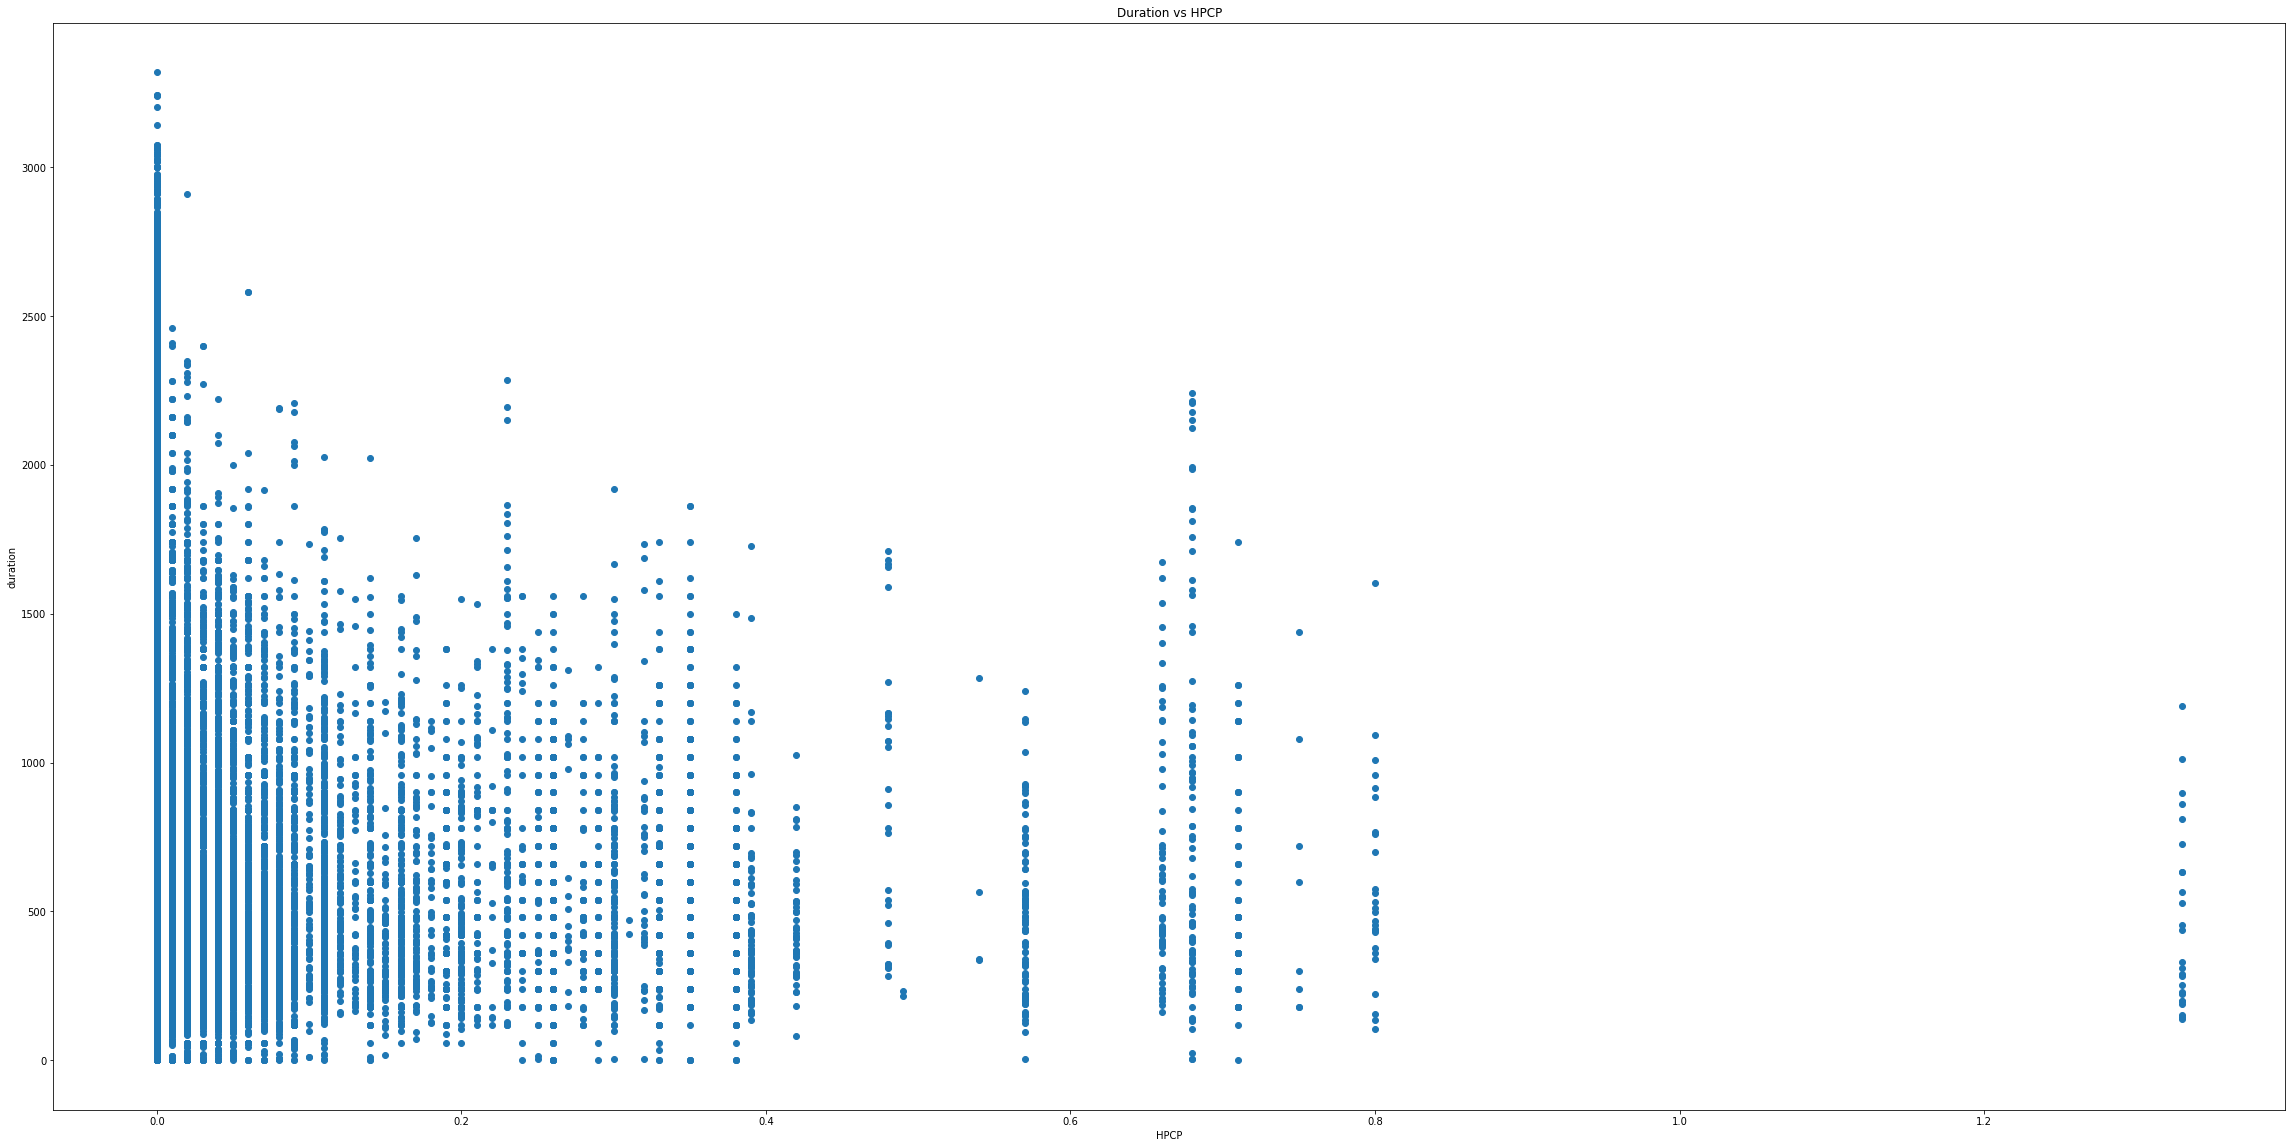

In [74]:
plt.figure(figsize=(40,20))
plt.scatter(trips.HPCP, trips.duration)
plt.title('Duration vs HPCP')
plt.xlabel('HPCP')
plt.ylabel('duration')
plt.show()

Interestingly enough, here there doesn't seem to be a distinct pattern at all, which should indicate that the hypothesis should be rejected. However, the discrepancy, the lack of structure, and the unclear relationship between the variables can be explained by the fact that there is more data for no precipitation than there was for any other precipitation value. Thus, I would argue that the results of this experiment were inconclusive. 

However, we do know for a fact that increased precipitation does lead to poorer travel conditions, which in turn could lead to longer travel times. Thus, I would still include it in the model.

## 3.4: Final creation of dummy variables

It is common practice to convert categorical data into "dummy" binary data, since the categorical data brings in a natural ordering for different classes. For example, if class_a has value 5 but class_b has value 24, is class_b ‘greater’ than class_a? The answer is no. Thus allowing model learning for these features will lead to poor performance. Therefore, for dataframe containing multi class features, a further step of converting these features to binary variables is needed. This will be accomplished manually with the code below.

In [75]:
# Create dummy features for these features, then drop these features

dummies = ['kmeans_start_time','start_month','start_weekday']

for feature in dummies:
    dummy_features = pd.get_dummies(trips[feature], prefix=feature)
    for dummy in dummy_features:
        trips[dummy] = dummy_features[dummy]
    trips = trips.drop([feature], 1)

In [76]:
# Sanity Check

trips.head()

duration          start_date  strt_statn  end_statn  \
0       432 2012-07-16 00:09:00        22.0        6.0   
1      1080 2013-06-24 00:09:00        14.0       66.0   
2       180 2013-06-24 00:09:00        55.0       45.0   
3       300 2013-06-24 00:09:00       103.0       46.0   
4       435 2012-07-16 00:09:00        22.0       47.0   

   start_minute_of_the_day  start_is_weekend  start_holiday  \
0                        9                 0              0   
1                        9                 0              0   
2                        9                 0              0   
3                        9                 0              0   
4                        9                 0              0   

   start_near_holiday  start_businessday  week_delta  ...  start_month_9  \
0                   0                  1     0.00625  ...              0   
1                   0                  1     0.00625  ...              0   
2                   0                  1     0.00625  ...              0   
3                   0                  1     0.00625  ...              0   
4                   0                  1     0.00625  ...              0   

   start_month_10  start_month_11  start_weekday_0  start_weekday_1  \
0               0               0                1                0   
1               0               0                1                0   
2               0               0                1                0   
3               0               0                1                0   
4               0               0                1                0   

   start_weekday_2  start_weekday_3  start_weekday_4  start_weekday_5  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   start_weekday_6  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 58 columns]

In addition, now that I have calculated all of the useful time information, we can drop the start_date feature.

In [77]:
trips = trips.drop('start_date', axis = 1)

In [78]:
# sanity check 

trips.columns

Index(['duration', 'strt_statn', 'end_statn', 'start_minute_of_the_day',
       'start_is_weekend', 'start_holiday', 'start_near_holiday',
       'start_businessday', 'week_delta', 'start_lat', 'start_long', 'end_lat',
       'end_long', 'distance', 'haversine_distance', 'manhattan_distance',
       'HPCP', 'kmeans_start_time_0', 'kmeans_start_time_1',
       'kmeans_start_time_2', 'kmeans_start_time_3', 'kmeans_start_time_4',
       'kmeans_start_time_5', 'kmeans_start_time_6', 'kmeans_start_time_7',
       'kmeans_start_time_8', 'kmeans_start_time_9', 'kmeans_start_time_10',
       'kmeans_start_time_11', 'kmeans_start_time_12', 'kmeans_start_time_13',
       'kmeans_start_time_14', 'kmeans_start_time_15', 'kmeans_start_time_16',
       'kmeans_start_time_17', 'kmeans_start_time_18', 'kmeans_start_time_19',
       'kmeans_start_time_20', 'kmeans_start_time_21', 'kmeans_start_time_22',
       'kmeans_start_time_23', 'start_month_3', 'start_month_4',
       'start_month_5', 'start_mont

## Final Comments:

The above workflow has shown that the selected subfeatures from the distance, time, and weather do impact the trip duration, meaning that all will be included in the training data

# Section 4: Splitting The Data

Splitting the data into a training set and a testing set is necessary for attaining good results (as we don't want to overfit our data onto one dataset). The two most common ways of splitting the data are using a "hold-out" set or cross-validation. Hold-out is when I split my data into a testing set and a training set. The most common splits are 70-30 and 80-20. 

Cross-validation or ‘k-fold cross-validation’ is when the dataset is randomly split up into ‘k’ groups. One of the groups is used as the test set and the rest are used as the training set. The model is trained on the training set and scored on the test set. Then the process is repeated until each unique group as been used as the test set.

However, while cross-validation is generally more robust, it requires more computational power and resources to run effectively and is thus most effective on small datasets. Thus, in this case where I have a large and complex dataset and limited time, I decided to use the hold-out approach to splitting the data.

Aa simple 70-30 split is appropiate for this dataset, as that is the most common split. First, though, we have to split the target variable (trip duration) from the training data.

In [79]:
y = trips.duration.values

In [80]:
# drop remaining the target variable from the trainin g data
trips = trips.drop(['duration'], axis = 1)

In [81]:
trips.head()

strt_statn  end_statn  start_minute_of_the_day  start_is_weekend  \
0        22.0        6.0                        9                 0   
1        14.0       66.0                        9                 0   
2        55.0       45.0                        9                 0   
3       103.0       46.0                        9                 0   
4        22.0       47.0                        9                 0   

   start_holiday  start_near_holiday  start_businessday  week_delta  \
0              0                   0                  1     0.00625   
1              0                   0                  1     0.00625   
2              0                   0                  1     0.00625   
3              0                   0                  1     0.00625   
4              0                   0                  1     0.00625   

   start_lat  start_long  ...  start_month_9  start_month_10  start_month_11  \
0  42.352175  -71.055547  ...              0               0               0   
1  42.337171  -71.102797  ...              0               0               0   
2  42.347265  -71.088088  ...              0               0               0   
3  42.348762  -71.082383  ...              0               0               0   
4  42.352175  -71.055547  ...              0               0               0   

   start_weekday_0  start_weekday_1  start_weekday_2  start_weekday_3  \
0                1                0                0                0   
1                1                0                0                0   
2                1                0                0                0   
3                1                0                0                0   
4                1                0                0                0   

   start_weekday_4  start_weekday_5  start_weekday_6  
0                0                0                0  
1                0                0                0  
2                0                0                0  
3                0                0                0  
4                0                0                0  

[5 rows x 56 columns]

In [82]:
# We will need this for training our models later
input_size = len(trips.columns)

print(input_size)

56


In [83]:
X = trips.values

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [85]:
# Sanity check

print(len(X_train), len(y_train))

print(len(X_test), len(y_test))

562544 562544
241091 241091


Scaling the data to have a mean of 0 and unit variance is good for training the data. This is done so that the variance of the features are in the same range. If a feature’s variance is orders of magnitude more than the variance of other features, that particular feature might dominate other features in the dataset, which is not something we want happening in our model.

In [86]:
std_scale = StandardScaler().fit(X_train)

X_train_std = std_scale.transform(X_train)

X_test_std  = std_scale.transform(X_test)

# Section 5: Model Selection and Evaluation

While I would ideally select the one model at the start, the best way to select the best algorithm would be train and test them all of them on our testing and training dataset. 

The models that we will be using are the models that are used for regression. These are linear regresson, random forest regression, Light GBM regression, neural networks, as well as one "dummy" classifier, which just always predicts the mean.


#### RMSE 

The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values. Whereas other ,ethods like R-Squared, RMSE is an absolute measure of fit. As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable, making it easier to explain errors. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction. This is why we chose RMSE for the model evaluation

## 5.1: Naive Classifier --> Always Predict Average

The reason for why this dummy classifier is chosen is because we need a baseline to measure model performance. Thus, any model chosen should have an error lower than the dummy classifier. Predicting the average is a robust "naive" model. 

In [87]:
avg_duration=round(np.mean(y_train),2) 

baseline_pred=np.repeat(avg_duration,y_test.shape[0])

baseline_rmse=np.sqrt(mean_squared_error(baseline_pred, y_test))

print("Basline RMSE of Naive Classifier :",baseline_rmse)

Basline RMSE of Naive Classifier : 428.1551684816391


## 5.2: Linear Regression

Linear Regression is useful in this case due to the speed of the calculation and is known to perform well on datasets that exhibit a linear relationship. While there isn't a clear linear relationship between the model, the speed of the model ensures that it is a low-risk, high reward inclusion. In addition, this could be used as an additional baseline (for the more complex models).

In [88]:
regression = LinearRegression().fit(X_train_std, y_train)

predictions_reg = regression.predict(X_test_std)

lr_rmse = np.sqrt(mean_squared_error(y_test, predictions_reg))

print("RMSE for Linear Regression on testing data is ",lr_rmse)

RMSE for Linear Regression on testing data is  328.98451776810566


In [89]:
predictions_reg_1 = regression.predict(X_train_std)

lr_rmse = np.sqrt(mean_squared_error(y_train, predictions_reg_1))

print("RMSE for Linear Regression on training data is ",lr_rmse)

RMSE for Linear Regression on training data is  329.5508929655499


## 5.3: Random Forest Regression

Ideally, we would like to minimize both error due to bias and error due to variance. Random forests mitigate this problem well. A random forest is simply a collection of decision trees whose results are aggregated into one final result. Their ability to limit overfitting without substantially increasing error due to bias is why they are such powerful models and why they will be chosen for this project.

In [90]:
Random_Forest = RandomForestRegressor(n_estimators = 100, max_features = 10, oob_score = True, 
                                      min_samples_leaf= 100).fit(X_train_std, y_train)


predictions_RF = Random_Forest.predict(X_test_std)

rf_rmse = np.sqrt(mean_squared_error(y_test, predictions_RF))

print("RMSE for Random Forest on testing data is ", rf_rmse)

RMSE for Random Forest on testing data is  298.4514771735665


In [91]:
predictions_RF = Random_Forest.predict(X_train_std)

rf_rmse = np.sqrt(mean_squared_error(y_train, predictions_RF))

print("RMSE for Random Forest on training data is ", rf_rmse)

RMSE for Random Forest on training data is  295.2199742546222


The training accuracy is slightly higher than the testing accuracy. However, it isn't too severe (I would argue that 3 seconds is acceptable), which means that the model does indeed provide a robust estimation

## 5.4: Light GBM

LightGBM is a boosting tree based algorithm. The difference between Light GBM and other tree-based algorithms, is that Light GBM grows leaf-wise instead of level-wise. This algorithm chooses the node which will result in maximum delta loss to split. Light GBM is very fast, takes quite less RAM to run, and focuses on the accuracy of the result, which explains why they were chosen for this project. 

In addition, I tried to use a CV grid to search for the most optimal hyperparameters. Unfortunately, after testing this with both the Random Forest and Light GBM, I found that the search took a large amount of time, meaning that I had to drop the method and had to resort to manual hyperparameter tuning. However, I did provide the code that I used to try and find the optimal hyperparameters for the light gbm below

In [92]:
train_data=lgb.Dataset(X_train_std,label=y_train)

param = {'num_leaves': 50, 'num_trees': 500,'objective':'regression'}

param['metric'] = 'l2_root'

In [93]:
lgb_bst =lgb.train(param,train_data, 500)

lgb_pred = lgb_bst.predict(X_test_std)

lgb_rmse=np.sqrt(mean_squared_error(lgb_pred, y_test))
print("RMSE for Light GBM on testing data is ",lgb_rmse)

/Users/nigel.hussain/anaconda3/envs/MLpy37/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSE for Light GBM on testing data is  289.4110030961705


In [94]:
lgb_pred = lgb_bst.predict(X_train_std)

lgb_rmse=np.sqrt(mean_squared_error(lgb_pred, y_train))

print("RMSE for Light GBM on training data is ",lgb_rmse)

RMSE for Light GBM on training data is  280.00718322024926


In [95]:
# This is the code that I would use for hyperparameter selection

# num_round=7000
# cv_results = lgb.cv(param, train_data, num_boost_round=num_round, nfold=10,verbose_eval=20, early_stopping_rounds=20,stratified=False)
# lgb_bst=lgb.train(param,train_data,len(cv_results['rmse-mean']))
# lgb_pred = lgb_bst.predict(X_test_std)
# lgb_rmse=np.sqrt(mean_squared_error(lgb_pred, y_test_std))
# print("RMSE for Light GBM is ",lgb_rmse)

The algorithm performs slightly better on the training data than on the testing data. However, it isn't too severe (I would argue that 9 seconds is an acceptable difference), meaning that the model does provide a robust prediction.

## 5.5: Tensorflow Neural Network

Since neural networks can have many layers (and thus parameters) with non-linearities, they are very effective at modelling highly complex non-linear relationships. We generally don’t have to worry about the structure of the data as neural networks are very flexible in learning almost any kind of feature variable relationships. Research has consistently shown that simply giving the network more training data, whether totally new or from augmenting the original data set, benefits network performance. Due to these characteristics and the large amount of data that we have, I believe that the neural network is a model that is worth testing. The Keras API of tensorflow was used due to time considerations.

In [96]:
# custom loss function: RMSE
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [97]:
model = Sequential()
model.add(Dense(25, input_dim=input_size, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics = [rmse])

In [98]:
model.fit(X_train_std, y_train, epochs=50, batch_size = 256)

Epoch 1/50
562544/562544 [==============================] - 6s 10us/step - loss: 187011.5706 - rmse: 303.9023
Epoch 2/50
562544/562544 [==============================] - 5s 9us/step - loss: 108158.8078 - rmse: 235.4185
Epoch 3/50
562544/562544 [==============================] - 5s 9us/step - loss: 106968.8049 - rmse: 233.7681
Epoch 4/50
562544/562544 [==============================] - 5s 9us/step - loss: 105677.7564 - rmse: 231.7167
Epoch 5/50
562544/562544 [==============================] - 5s 9us/step - loss: 103102.7821 - rmse: 227.5427
Epoch 6/50
562544/562544 [==============================] - 5s 9us/step - loss: 101575.0221 - rmse: 225.3378
Epoch 7/50
562544/562544 [==============================] - 5s 9us/step - loss: 100883.2202 - rmse: 224.3993
Epoch 8/50
562544/562544 [==============================] - 6s 10us/step - loss: 100340.1631 - rmse: 223.6698
Epoch 9/50
562544/562544 [==============================] - 5s 9us/step - loss: 99804.0568 - rmse: 222.9724
Epoch 10/50
562544

In [99]:
predictions_NN = model.predict(X_test_std)
nn_rmse = np.sqrt(mean_squared_error(y_test, predictions_NN))
print("RMSE for Neural Network on testing data is ", nn_rmse)

RMSE for Neural Network on testing data is  309.2479991515117


In [100]:
predictions_NN = model.predict(X_train_std)
nn_rmse = np.sqrt(mean_squared_error(y_train, predictions_NN))
print("RMSE for Neural Network on training data is ", nn_rmse)

RMSE for Neural Network on training data is  309.0666914813166


## 5.6: Comments:

Interestingly, all of ther models in this case performed very similarly, although the more complex models, as in the neural newtork, gbm, and the random forest method unsurprisingly outperformed the simpler linear regression model. The models that shows the most promise are the Light GBM model (as it had the lowest overall error and didn't severly overfit the training data--> only a difference of around 10 seconds), meaning that at this point I would choose the light GBM for further predictions (and tuning).

# Section 6: Final Remarks

In this section, I reflect on the project.

##  6.1: Final Thoughts: DataSet

While the dataset provided does yield a good amount of features (which can all be transformed), I would argue that there are some additional features that I would incorporate into a future project.

One feature of the dataset, specifically regarding the target variable, is that we would have to assume a direct trip for each bicycle trip (as in a trip from station 40 to station 3 is a direct  and doesn't stop at various places along the way e.g. a sightseeing tour). If there are trips in the dataset which are not direct, then that could have a big impact on the duration of the trip (as it would take longer) and thus would interfere with the accuracy of our predictions. Thus, while collecting data next time, I could probably ask if a trip was part of a sight-seeing tour or some other "roundabout" trip and incorporate those features accordingly.

In addition, there was a lack of traffic data. While I did attempt to estimate this using the number of bikes on the road,  the estimate was crude at best and doesn't take into account pedestrian traffic or other vehicular traffic. Thus, when performing this experiment again, I would attempt to get some more traffic data at each time and incorporate those as features into my dataset. For example, if I found out that there was a heavy amount of traffic during a specific time, which led to greater trip durations then I would create a "dummy" feature called (travel_at_x, with either 0 or 1 as an output) to account for this.

Finally, while the precipitation data was useful, I believe that more information regarding the types of weather condition (snow, etc.) as well as their effect on the roads (poor road and thus poor traveling conditions) would also generate better prediction as well.

## 6.2: Thing(s) I would have done differently

1) Perhaps foremost is that I would have tried to incorporate a hyperparameter search into my workflow, specifically for the Light GBM methods and the Random Forest, which would benefit the most from this kind of search.

2) In addition, if there was more memory and computational resources available, I would try and use a Random Forest model with a greater number of trees and deeper neural networks

3) I would also try to incorporate other regularisation methods (L1 and L2) to improve model accuracy and explore additional ways of removing outliers, add try and incorporate different features

## 6.3: Model Fit

While the errors themselves (289-319) might seem a bit high, it is important to take into consideration the range of the target variables. In this case, the range of the target variables is [0, 3960]. The mean of the range is 747 and the standard deviation is 487. Thus, since our error is in the low percentile, I would argue that the model itself still is accurate and thus can be a good fit. However, there is still room for improvement, which can be accomplished with additional data as well as proper hyperparameter selection. 

In addition, the training and testing errors were around the same for all of our models (with the largest discrepance being only 10 seconds), meaning that our models provided a robust estimation of the target variable (good generalisation overall).

Finally, I also used all of the selected machine learning models on the initial training data without any sort of feature engineering or data wrangling (see below), meaning that the only features included in the training data were the start_statn and end station. This was done to visualise the improvement, which in this case was over 13000 seconds. 

###### Error for initial training: 

Linear Regression testing RMSE: 13336.974662849358

Random Forest testing RMSE: 13368.469954703412

Light GBM testing RMSE: 14616.713902695517

Neural Network testing RMSE: 13333.288434061327



###### Errors after Feature Extraction/Data Cleaning

Linear Regression testing RMSE: 328.98451776810566

Random Forest testing RMSE: 298.4514771735665

Light GBM testing RMSE: 289.4110030961705

Neural Network testing RMSE: 309.2479991515117

## 6.4: Workflow Justification

The first step of any machine learning workflow is to always import the data as a dataframe, as this data structure allows us to easily visualise and manipulate the data.


#### Data Cleaning/Preprocessing:

Sometimes the data is spread into many different tables that have to be unified into one. And then you will have missing values (null and NaN), or just a bunch of zeros or some kind of Null Island, or numbers that are stupidly large, it must be a mistake. There are so many ways things can go wrong, and most of the time, they do. Furthermore, if the data is bad, then we are going to get bad results ( see initial ML results), making it is imperative to deal with the data preprocessing and cleaning before any other steps are made. For example, regarding the biycle case, it is unreasonable to assume that a direct bicycle trip would normally last over 4 hours, especially at a time when there is little to no traffic. Thus, I dealt with all of the null values and performed an initial outlier removal using some knowledge of bicycle traveling times before anything else. 




#### Feature Extraction/Insight Generation/Hypothesis Testing:

The features in the data will directly influence the predictive models used and the results that can be achieved. 

Better features means flexibility. Most models can pick up on good structure in data. The flexibility of well-engineered features will allow you to use less complex models that are faster to run, easier to understand and easier to maintain. This is very desirable.

With good features, you are closer to the underlying problem and a representation of all the data you have available and could use to best characterize that underlying problem.

In addition, exploring different features could also generate more insights onto the nature of the outliers in the group. For example, by exploring the week delta, I was able to see that even after the initial outlier removal, some of the travel times were still a bit nonsensical (4 hours is still a bit too much, especially during the less busy times of the day)

However, not all features are created equally. Thus, it is important to test the effect of each feature on the target variable. The best way to do this is to create a hypothesis about the nature of the effect of the feature and choosing the feature based on the impact it had on the target variable, which is how I approached feature engineering.  


#### Splitting the Data

Unfortunately, training and testing our model on just one dataset could inhibit the model's ability to generalise (on unseen data) and predict on unseen data, as we are essentially letting the model memorise the structure of the data that we have been using.

The solution is to have a train/test split. Let our model be trained on the training set, and be tested on the testing a set, a set that it has never seen before, to see if the model is able to generalize to not previously seen dataset. There are different ways of doing this that were outlined in the corresponding section

After splitting the data, it is also wise to scale the data accordingly. Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance). If a feature has a variance that is orders of magnitude larger that others, it might dominate the predictions and make the estimator unable to learn from other features correctly as expected.


#### Model Selection

In machine learning, there’s something called the “No Free Lunch” theorem which basically states that no one ML algorithm is best for all problems. The performance of different ML algorithms strongly depends on the size and structure of the data. Thus, the correct choice of algorithm often remains unclear unless we test out our algorithms directly through plain old trial and error. In addition, the algorithms that chosen were the ones that are used quite frequently in regression and I chose the one that had the best overall performance.

Furthermore, the evaluation step lets us assess the hyperparameters of the model and use the most optimal ones. In this case, they were tuned manually due to a lack of time.


#### Final

Since my approach was able to significantly reduce the error (by over 13000 seconds) and produce models that provide robust predictions (no severe overfitting or underfitting), I would argue that this is the best indicator of a good workflow and methodology.

# Section 7: Initial Predictions without any Feature Engineering/Data Cleaning

This section just shows how the models woukd fare without any of the preprocessing and feature engineering that was done, and these errors were used as a baseline (any manipulation or feature engineering done should result in a lower error, not a higher one).

## 7.1: Read Data

In [101]:
trips_2 = pd.read_csv('hubway_trips.csv')

trips_2 = trips_2.drop(['start_date', 'status','end_date', 'zip_code','birth_date','gender', 'bike_nr', 'seq_id', 'hubway_id', 'subsc_type'], 1)

trips_2.head()

trips_2 = trips_2.dropna()

## 7.2: Split data

In [102]:
y_2 = trips_2.duration.values

trips_2 = trips_2.drop('duration', axis=1)

X_2 = trips_2.values

X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, y_2, test_size = 0.3, random_state=42)

## 7.3: LR

In [103]:
regression = LinearRegression().fit(X2_train, y2_train)

predictions_reg_2 = regression.predict(X2_test)

lr_rmse_2 = np.sqrt(mean_squared_error(y2_test, predictions_reg_2))

print("RMSE for Linear Regression on testing data is ",lr_rmse_2)

RMSE for Linear Regression on testing data is  13336.974662849358


In [104]:
predictions_reg_2 = regression.predict(X2_train)

lr_rmse_2 = np.sqrt(mean_squared_error(y2_train, predictions_reg_2))

print("RMSE for Linear Regression on training data is ",lr_rmse_2)

RMSE for Linear Regression on training data is  23649.530047982113


## 7.4: RF

In [105]:
Random_Forest = RandomForestRegressor(n_estimators = 100, max_features = 2, oob_score = True, 
                                      min_samples_leaf= 100).fit(X2_train, y2_train)


predictions_RF_2 = Random_Forest.predict(X2_test)

rf_rmse_2 = np.sqrt(mean_squared_error(y2_test, predictions_RF_2))

print("RMSE for Random Forest on testing data is ", rf_rmse_2)

RMSE for Random Forest on testing data is  13379.764097831547


In [106]:
predictions_RF_2 = Random_Forest.predict(X2_train)

rf_rmse_2 = np.sqrt(mean_squared_error(y2_train, predictions_RF_2))

print("RMSE for Random Forest on training data is ", rf_rmse_2)

RMSE for Random Forest on training data is  23583.166266859855


## 7.5: Light GBM

In [107]:
train_data=lgb.Dataset(X2_train,label=y2_train)

param = {'num_leaves': 50, 'num_trees': 500,'objective':'regression'}

param['metric'] = 'l2_root'

In [108]:
lgb_bst =lgb.train(param,train_data, 500)

lgb_pred_2 = lgb_bst.predict(X2_test)

lgb_rmse_2=np.sqrt(mean_squared_error(lgb_pred_2, y2_test))

print("RMSE for Light GBM on testing data is ",lgb_rmse_2)

/Users/nigel.hussain/anaconda3/envs/MLpy37/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSE for Light GBM on testing data is  14616.713902695517


In [109]:
lgb_pred_2 = lgb_bst.predict(X2_train)

lgb_rmse_2 =np.sqrt(mean_squared_error(lgb_pred_2, y2_train))

print("RMSE for Light GBM on training data is ",lgb_rmse_2)

RMSE for Light GBM on training data is  22278.99550594118


## 7.6: Tensorflow Neural Network

In [110]:
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics = [rmse])

In [111]:
model.fit(X2_train, y2_train, epochs=50, batch_size = 256)

Epoch 1/50
733966/733966 [==============================] - 7s 10us/step - loss: 559807754.3603 - rmse: 1054.4846
Epoch 2/50
733966/733966 [==============================] - 6s 9us/step - loss: 559740252.8562 - rmse: 1047.4902
Epoch 3/50
733966/733966 [==============================] - 6s 9us/step - loss: 559718203.2778 - rmse: 1047.3203
Epoch 4/50
733966/733966 [==============================] - 8s 10us/step - loss: 559690288.5688 - rmse: 1046.8677
Epoch 5/50
733966/733966 [==============================] - 7s 10us/step - loss: 559648561.6207 - rmse: 1045.8176
Epoch 6/50
733966/733966 [==============================] - 6s 9us/step - loss: 559592548.9072 - rmse: 1042.9728
Epoch 7/50
733966/733966 [==============================] - 6s 9us/step - loss: 559500434.0987 - rmse: 1048.3685
Epoch 8/50
733966/733966 [==============================] - 6s 9us/step - loss: 559421465.3599 - rmse: 1055.7993
Epoch 9/50
733966/733966 [==============================] - 6s 9us/step - loss: 559367409.431

In [112]:
predictions_NN_2 = model.predict(X2_test)
nn_rmse_2 = np.sqrt(mean_squared_error(y2_test, predictions_NN_2))
print("RMSE for Neural Network on testing data is ", nn_rmse_2)

RMSE for Neural Network on testing data is  13332.676892442269


In [113]:
predictions_NN_2 = model.predict(X2_train)
nn_rmse_2 = np.sqrt(mean_squared_error(y2_train, predictions_NN_2))
print("RMSE for Neural Network on training data is ", nn_rmse_2)

RMSE for Neural Network on training data is  23647.50310761543



##### Thank you considering my application and providing me with the coding challenge. It was a challenging, but very enjoyable experience that I learned a lot from.  I look forward to hearing feedback.